# Instâncias reais

* **timestamp**: observations timestamps loaded into pandas DataFrame as its index;
* **P-PDG**: pressure variable at the Permanent Downhole Gauge (PDG);
* **P-TPT**: pressure variable at the Temperature and Pressure Transducer (TPT);
* **T-TPT**: temperature variable at the Temperature and Pressure Transducer (TPT);
* **P-MON-CKP**: pressure variable upstream of the production choke (CKP);
* **T-JUS-CKP**: temperature variable downstream of the production choke (CKP);
* **P-JUS-CKGL**: pressure variable upstream of the gas lift choke (CKGL);
* **T-JUS-CKGL**: temperature variable upstream of the gas lift choke (CKGL);
* **QGL**: gas lift flow rate;
* **class**: observations labels associated with three types of periods (normal, fault transient, and faulty steady state).


* **label**: instance label (event type);
* **well**: well name. Hand-drawn and simulated instances have fixed names. Real instances have names masked with incremental id;
* **id**: instance identifier. Hand-drawn and simulated instances have incremental id. Each real instance has an id generated from its first timestamp.

In [1]:
import sys
import os
import pandas as pd
import numpy as np

import joblib
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.metrics  import average_precision_score, make_scorer, roc_curve,f1_score, precision_score, recall_score, fbeta_score, auc, roc_auc_score, accuracy_score, confusion_matrix, classification_report,precision_recall_curve
import seaborn as sns

import matplotlib.pyplot as plt

import shap

from pyod.models.ecod import ECOD

from pyod.models.suod import SUOD

from pyod.models.xgbod import XGBOD

from pyod.models.loda import LODA

from pyod.models.pca import PCA

from sklearn.neighbors import LocalOutlierFactor

from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

from sklearn.neighbors import LocalOutlierFactor

from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDOneClassSVM
from sklearn.pipeline import make_pipeline
from sklearn.svm import OneClassSVM

import plotly.graph_objects as go

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


c:\Users\User\anaconda3\envs\PHD\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import plotly.graph_objects as go

In [3]:
def metrics(y_test, y_pred):
    cm = list()
    cm = confusion_matrix(y_test, y_pred)
    cm_df = pd.DataFrame(cm)                      
    plt.figure(figsize=(8,6))  
    sns.heatmap(cm_df, annot=True)
    print("Classification Report: \n", classification_report(y_test, y_pred, digits=5))  


    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]

    print("Specificity:", TN/(TN+FP))


    roc_auc = roc_auc_score(y_test, y_pred, multi_class = 'ovr', average=None)
    gini = 2*roc_auc -1
    print("Gini: ",gini)
    print("ROC AUC:: ",roc_auc)

In [4]:
class ToDataFrameTransformer(BaseEstimator, TransformerMixin):
    """
    Transformador para converter arrays NumPy em DataFrames, mantendo os nomes das colunas.
    """
    def __init__(self, columns=None):
        self.columns = columns
    
    def fit(self, X, y=None):
        # Não há nada para ajustar, apenas retorna o próprio objeto
        return self

    def transform(self, X):
        # Converte o array NumPy em DataFrame com os nomes das colunas fornecidos
        if self.columns is not None:
            return pd.DataFrame(X, columns=self.columns)
        return pd.DataFrame(X)

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

In [5]:
def plot_learning_curve_cross_validation(df, title, ylim=None, train_sizes=np.linspace(1, 1000, 1000)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    # plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Interações")
    plt.ylabel("AUC-ROC")

    test_scores_mean = df.mean_test_roc_auc
    test_scores_std = df.std_test_roc_auc
    plt.grid()

    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, color="g",
             label="Validação cruzada")

    plt.legend(loc="best")
    return plt

In [6]:
train = pd.read_parquet('./dataset/train_agg_full.parquet.gzip') 
test = pd.read_parquet('./dataset/test_agg_full.parquet.gzip') 

In [7]:
train.head()

,well,timestamp,P-PDG_mean,P-PDG_std,P-PDG_min,P-PDG_max,P-TPT_mean,P-TPT_std,P-TPT_min,P-TPT_max,...,P-MON-CKP_max,T-JUS-CKP_mean,T-JUS-CKP_std,T-JUS-CKP_min,T-JUS-CKP_max,P-JUS-CKGL_mean,P-JUS-CKGL_std,P-JUS-CKGL_min,P-JUS-CKGL_max,target
0,WELL-00001,2014-01-24 09:30:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397099.0,74.800278,0.000019,74.80025,74.80031,-300917.8,0.0,-300917.8,-300917.8,1.0
1,WELL-00001,2014-01-24 09:35:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397272.0,74.800168,0.000046,74.80009,74.80025,-300917.8,0.0,-300917.8,-300917.8,1.0
2,WELL-00001,2014-01-24 09:40:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397446.0,74.800010,0.000047,74.79993,74.80009,-300917.8,0.0,-300917.8,-300917.8,1.0
3,WELL-00001,2014-01-24 09:45:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397621.0,74.799852,0.000047,74.79977,74.79993,-300917.8,0.0,-300917.8,-300917.8,1.0
4,WELL-00001,2014-01-24 09:50:00,0.0,0.0,0.0,0.0,18433410.0,0.0,18433410.0,18433410.0,...,9397795.0,74.799693,0.000047,74.79961,74.79977,-300917.8,0.0,-300917.8,-300917.8,1.0


In [8]:
test.head()

,well,timestamp,P-PDG_mean,P-PDG_std,P-PDG_min,P-PDG_max,P-TPT_mean,P-TPT_std,P-TPT_min,P-TPT_max,...,P-MON-CKP_max,T-JUS-CKP_mean,T-JUS-CKP_std,T-JUS-CKP_min,T-JUS-CKP_max,P-JUS-CKGL_mean,P-JUS-CKGL_std,P-JUS-CKGL_min,P-JUS-CKGL_max,target
376538,WELL-00001,2017-08-23 19:40:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.686840e+06,6237.435951,9675544.0,9695493.0,...,1953795.0,84.367123,0.230657,83.58832,84.70229,-140331.8,0.0,-140331.8,-140331.8,0.0
376539,WELL-00001,2017-08-23 19:45:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.691381e+06,7063.428971,9679208.0,9703555.0,...,1950179.0,83.149974,0.159885,82.87943,83.56806,-140331.8,0.0,-140331.8,-140331.8,0.0
376540,WELL-00001,2017-08-23 19:50:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.710671e+06,3047.495846,9703636.0,9715443.0,...,1798996.0,83.693227,0.168539,83.40104,83.95795,-140331.8,0.0,-140331.8,-140331.8,0.0
376541,WELL-00001,2017-08-23 19:55:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.700290e+06,5400.736360,9683720.0,9708045.0,...,1835164.0,83.880155,0.040774,83.80988,83.95042,-140331.8,0.0,-140331.8,-140331.8,0.0
376542,WELL-00001,2017-08-23 20:00:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.687219e+06,5027.774671,9675544.0,9695493.0,...,1937881.0,83.739377,0.040907,83.66887,83.80942,-140331.8,0.0,-140331.8,-140331.8,0.0


In [9]:
train.target.value_counts()

target
0.0    22051
1.0    10887
Name: count, dtype: int64

In [10]:
development = train.reset_index(drop=True)

# development = development[(development['well']=='WELL-00006')].reset_index(drop=True)

development.shape

(32938, 27)

In [11]:
validation = test.reset_index(drop=True)
validation.shape

(8241, 27)

In [12]:
validation.head()

,well,timestamp,P-PDG_mean,P-PDG_std,P-PDG_min,P-PDG_max,P-TPT_mean,P-TPT_std,P-TPT_min,P-TPT_max,...,P-MON-CKP_max,T-JUS-CKP_mean,T-JUS-CKP_std,T-JUS-CKP_min,T-JUS-CKP_max,P-JUS-CKGL_mean,P-JUS-CKGL_std,P-JUS-CKGL_min,P-JUS-CKGL_max,target
0,WELL-00001,2017-08-23 19:40:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.686840e+06,6237.435951,9675544.0,9695493.0,...,1953795.0,84.367123,0.230657,83.58832,84.70229,-140331.8,0.0,-140331.8,-140331.8,0.0
1,WELL-00001,2017-08-23 19:45:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.691381e+06,7063.428971,9679208.0,9703555.0,...,1950179.0,83.149974,0.159885,82.87943,83.56806,-140331.8,0.0,-140331.8,-140331.8,0.0
2,WELL-00001,2017-08-23 19:50:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.710671e+06,3047.495846,9703636.0,9715443.0,...,1798996.0,83.693227,0.168539,83.40104,83.95795,-140331.8,0.0,-140331.8,-140331.8,0.0
3,WELL-00001,2017-08-23 19:55:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.700290e+06,5400.736360,9683720.0,9708045.0,...,1835164.0,83.880155,0.040774,83.80988,83.95042,-140331.8,0.0,-140331.8,-140331.8,0.0
4,WELL-00001,2017-08-23 20:00:00,-6887865.0,0.0,-6887865.0,-6887865.0,9.687219e+06,5027.774671,9675544.0,9695493.0,...,1937881.0,83.739377,0.040907,83.66887,83.80942,-140331.8,0.0,-140331.8,-140331.8,0.0


In [13]:
# validation_well = validation[(validation['well']=='WELL-00006')].reset_index(drop=True)

# validation_well.shape

In [14]:
train_no_anomalies = development[development.target==0]
train_no_anomalies.shape

(22051, 27)

In [15]:
feature_model = [col for col in train.columns if col not in ['timestamp', 'well', 'target']]
feature_model

['P-PDG_mean',
 'P-PDG_std',
 'P-PDG_min',
 'P-PDG_max',
 'P-TPT_mean',
 'P-TPT_std',
 'P-TPT_min',
 'P-TPT_max',
 'T-TPT_mean',
 'T-TPT_std',
 'T-TPT_min',
 'T-TPT_max',
 'P-MON-CKP_mean',
 'P-MON-CKP_std',
 'P-MON-CKP_min',
 'P-MON-CKP_max',
 'T-JUS-CKP_mean',
 'T-JUS-CKP_std',
 'T-JUS-CKP_min',
 'T-JUS-CKP_max',
 'P-JUS-CKGL_mean',
 'P-JUS-CKGL_std',
 'P-JUS-CKGL_min',
 'P-JUS-CKGL_max']

In [16]:
development

,well,timestamp,P-PDG_mean,P-PDG_std,P-PDG_min,P-PDG_max,P-TPT_mean,P-TPT_std,P-TPT_min,P-TPT_max,...,P-MON-CKP_max,T-JUS-CKP_mean,T-JUS-CKP_std,T-JUS-CKP_min,T-JUS-CKP_max,P-JUS-CKGL_mean,P-JUS-CKGL_std,P-JUS-CKGL_min,P-JUS-CKGL_max,target
0,WELL-00001,2014-01-24 09:30:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397099.0,74.800278,0.000019,74.80025,74.80031,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
1,WELL-00001,2014-01-24 09:35:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397272.0,74.800168,0.000046,74.80009,74.80025,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
2,WELL-00001,2014-01-24 09:40:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397446.0,74.800010,0.000047,74.79993,74.80009,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
3,WELL-00001,2014-01-24 09:45:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397621.0,74.799852,0.000047,74.79977,74.79993,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
4,WELL-00001,2014-01-24 09:50:00,0.0,0.0,0.0,0.0,1.843341e+07,0.000000,18433410.0,18433410.0,...,9397795.0,74.799693,0.000047,74.79961,74.79977,-3.009178e+05,0.000000,-300917.8,-300917.8,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32933,WELL-00018,2019-04-03 09:40:00,0.0,0.0,0.0,0.0,8.431093e+06,712.726134,8429578.0,8432542.0,...,1483602.0,74.213973,0.110205,74.00000,74.36111,9.397205e+06,4166.921226,9390495.0,9404494.0,1.0
32934,WELL-00018,2019-04-03 09:45:00,0.0,0.0,0.0,0.0,8.430980e+06,678.090498,8429752.0,8432400.0,...,1457574.0,74.000000,0.000000,74.00000,74.00000,9.410833e+06,5949.398514,9404543.0,9427083.0,1.0
32935,WELL-00018,2019-04-03 09:50:00,0.0,0.0,0.0,0.0,8.430743e+06,911.513084,8429560.0,8433425.0,...,1457574.0,74.000000,0.000000,74.00000,74.00000,9.427372e+06,1767.329397,9427083.0,9442866.0,1.0
32936,WELL-00018,2019-04-03 09:55:00,0.0,0.0,0.0,0.0,8.430795e+06,485.347977,8429913.0,8432119.0,...,1474926.0,74.000000,0.000000,74.00000,74.00000,9.444548e+06,340.325177,9444444.0,9446233.0,1.0


In [17]:
X_dev = development[feature_model].values
y_dev = development['target'].values

In [18]:
y_dev.sum()

10887.0

In [19]:
len(y_dev)

32938

In [20]:
X_no_anomalies = train_no_anomalies[feature_model].values

In [21]:
# import numpy as np
# import gym
# from gym import spaces
# from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import TimeSeriesSplit
# import time
# from stable_baselines3 import SAC

# class AnomalyDetectionEnv(gym.Env):
#     def __init__(self, X, y, tscv, features, model_factory, param_ranges):
#         """
#         Ambiente de RL para otimização de modelos de detecção de anomalias.

#         :param X: Dados de entrada (numpy array)
#         :param y: Rótulos (numpy array)
#         :param tscv: TimeSeriesSplit para validação cruzada
#         :param features: Lista de features usadas
#         :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
#         :param param_ranges: Dicionário com limites inferior e superior para cada hiperparâmetro
#         """
#         super(AnomalyDetectionEnv, self).__init__()

#         self.X = X
#         self.y = y
#         self.tscv = tscv
#         self.features = features
#         self.model_factory = model_factory
#         self.param_ranges = param_ranges

#         # Definir espaço de ação com base nos hiperparâmetros do modelo
#         low_bounds = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)
#         high_bounds = np.array([param_ranges[p][1] for p in param_ranges], dtype=np.float32)
#         self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

#         # Estado = Últimos hiperparâmetros escolhidos
#         self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

#         # Estado inicial (média dos limites)
#         self.state = np.array([(param_ranges[p][0] + param_ranges[p][1]) / 2 for p in param_ranges], dtype=np.float32)

#         # Histórico de métricas
#         self.metrics_history = {
#             'f1_score': [],
#             'precision': [],
#             'recall': [],
#             'roc_auc': [],
#             'specificity': []
#         }

#     def step(self, action):
#         # Verificar se a ação contém NaN
#         if np.isnan(action).any():
#             print("Ação inválida detectada:", action)
#             return self.reset(), 0, True, {"invalid_action": True}

#         # Criar dicionário de hiperparâmetros ajustados dentro dos limites
#         params = {key: np.clip(action[i], *self.param_ranges[key]) for i, key in enumerate(self.param_ranges)}

#         # Criar o modelo com os hiperparâmetros selecionados
#         model = self.model_factory(params)

#         # Pipeline de pré-processamento e modelo
#         pipeline = Pipeline([
#             ('scaler', StandardScaler()),
#             ('model', model)
#         ])

#         # Validação cruzada e avaliação do modelo
#         split_scores = {
#             'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'specificity': [], 'fit_time': [], 'score_time': []
#         }

#         for train_index, test_index in self.tscv.split(self.X):
#             # Filtrar apenas eventos normais no treinamento
#             X_train_split = self.X[train_index][self.y[train_index] == 0]
            
#             X_test_split = self.X[test_index]
#             y_test_split = self.y[test_index]

#             start_fit = time.time()
#             pipeline.fit(X_train_split)
#             fit_time = time.time() - start_fit

#             start_score = time.time()
#             y_scores = pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
#             y_pred = pipeline.predict(X_test_split)
#             score_time = time.time() - start_score

#             # Mapear previsões para anomalias (0 = normal, 1 = anomalia)
#             y_pred = np.where(y_pred == -1, 1, 0)

#             # Calcular métricas
#             precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
#             recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
#             f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
#             roc_auc = roc_auc_score(y_test_split, y_scores)

#             # Calcular especificidade
#             tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
#             specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

#             split_scores['f1_score'].append(f1)
#             split_scores['precision'].append(precision)
#             split_scores['recall'].append(recall)
#             split_scores['roc_auc'].append(roc_auc)
#             split_scores['specificity'].append(specificity)
#             split_scores['fit_time'].append(fit_time)
#             split_scores['score_time'].append(score_time)

#         # Recompensa baseada na média do AUC-ROC
#         reward = np.mean(split_scores['roc_auc'])
#         for metric in self.metrics_history:
#             self.metrics_history[metric].append(np.mean(split_scores[metric]))

#         # Atualizar estado
#         self.state = np.array(list(params.values()), dtype=np.float32)

#         return self.state, reward, True, {}

#     def reset(self):
#         self.state = np.array([(self.param_ranges[p][0] + self.param_ranges[p][1]) / 2 for p in self.param_ranges], dtype=np.float32)
#         return self.state

#     def render(self, mode='human'):
#         pass


In [22]:
import numpy as np
import gym
from gym import spaces
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import time

class AnomalyDetectionEnv(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior e superior para cada hiperparâmetro
        """
        super(AnomalyDetectionEnv, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Espaço de ação baseado nos hiperparâmetros
        low_bounds = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)
        high_bounds = np.array([param_ranges[p][1] for p in param_ranges], dtype=np.float32)
        self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Espaço de observação (hiperparâmetros atuais)
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Estado inicial: média dos limites dos hiperparâmetros
        # self.state = np.array([(param_ranges[p][0] + param_ranges[p][1]) / 2 for p in param_ranges], dtype=np.float32)
        self.state = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)

        # Histórico de métricas
        self.metrics_history = {
            'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': []
        }

        self.rewards_history = []  # Histórico de recompensas
        self.q_values_history = []  # Histórico de Q-values
        self.entropy_history = []  # Histórico de entropia
        self.critic_loss_history = []  # Histórico de critic loss

        # Lista para armazenar os resultados detalhados de cada rodada
        self.results = []

    # def find_optimal_threshold(self, y_true, y_scores, metric='f1'):
    #     precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
    #     try:
    #         f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    #     except:
    #           f1_scores = 0    
    #     best_idx = np.argmax(f1_scores)
    #     return thresholds[best_idx], f1_scores[best_idx]

    def step(self, action):
        # Verificar se a ação contém valores inválidos
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        # Criar dicionário de hiperparâmetros ajustados dentro dos limites
        params = {key: np.clip(action[i], *self.param_ranges[key]) for i, key in enumerate(self.param_ranges)}

        # Criar o modelo com os hiperparâmetros escolhidos
        model = self.model_factory(**params)

        # Pipeline de pré-processamento e modelo
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Validação cruzada e avaliação do modelo
        split_scores = {
            'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': [], 'fit_time': [], 'score_time': []
        }

        for train_index, test_index in self.tscv.split(self.X):
            # Filtrar apenas eventos normais no conjunto de treinamento
            X_train_split = self.X[train_index][self.y[train_index] == 0]

            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            start_fit = time.time()
            pipeline.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = -pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
            y_pred = pipeline.predict(X_test_split)
            score_time = time.time() - start_score

            # Mapear previsões para anomalias (0 = normal, 1 = anomalia)
            y_pred = np.where(y_pred == -1, 1, 0)
            # best_threshold, best_f1 = self.find_optimal_threshold(y_test_split, y_scores)
            # y_pred = (y_scores >= best_threshold).astype(int)

            # Calcular métricas
            precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
            roc_auc = roc_auc_score(y_test_split, y_scores)
            # try:
            #     roc_auc = roc_auc_score(y_test_split, y_pred)
            # except:
                # roc_auc=0    
            pr_auc = average_precision_score(y_test_split, y_scores)      

            # Calcular especificidade
            tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            split_scores['f1_score'].append(f1)
            split_scores['precision'].append(precision)
            split_scores['recall'].append(recall)
            split_scores['roc_auc'].append(roc_auc)
            split_scores['pr_auc'].append(pr_auc)
            split_scores['specificity'].append(specificity)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        # Adicionar resultados detalhados
        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            "mean_test_f1_score": np.mean(split_scores['f1_score']),
            "std_test_f1_score": np.std(split_scores['f1_score']),
            "mean_test_specificity": np.mean(split_scores['specificity']),
            "std_test_specificity": np.std(split_scores['specificity']),
            "mean_test_precision": np.mean(split_scores['precision']),
            "std_test_precision": np.std(split_scores['precision']),
            "mean_test_recall": np.mean(split_scores['recall']),
            "std_test_recall": np.std(split_scores['recall']),
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            "mean_test_pr_auc": np.mean(split_scores['pr_auc']),
            "std_test_pr_auc": np.std(split_scores['pr_auc']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        # Recompensa baseada no AUC-ROC médio
        reward = 100*(np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))

        # reward = 2 * np.mean(split_scores['roc_auc']) - 1  # Gini

        # reward = np.mean(split_scores['f1_score'])
        # reward = np.mean(split_scores['pr_auc'])

        self.rewards_history.append(reward)

        # Atualizar histórico de métricas
        for metric in self.metrics_history:
            self.metrics_history[metric].append(np.mean(split_scores[metric]))

        # Atualizar estado
        self.state = np.array(list(params.values()), dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([(self.param_ranges[p][0] + self.param_ranges[p][1]) / 2 for p in self.param_ranges], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        """ Retorna um DataFrame com os resultados da validação cruzada. """
        return pd.DataFrame(self.results)
    

# from sklearn.ensemble import IsolationForest

# def isolation_forest_factory(**params):
#     return IsolationForest(
#         n_estimators=int(params['n_estimators']),
#         contamination=params['contamination'],
#         max_samples=params['max_samples'],
#         max_features=int(params['max_features']),
#         # bootstrap=bool(params['bootstrap']),
#         random_state=42
#     )

# param_ranges_if = {
#     'n_estimators': (50, 256),
#     'contamination': (0.001, 0.01),
#     'max_samples': (0.7, 1.0),
#     'max_features': (0.7, 1.0)
#     # 'bootstrap': (0, 1)  # 0 = False, 1 = True
# }


# # === Configuração do TimeSeriesSplit ===
# tscv = TimeSeriesSplit(n_splits=3)

# # === Configuração do Ambiente e SAC ===
# # env = IsolationForestEnv(X, y, tscv, feature_model)
# env = AnomalyDetectionEnv(X, y, tscv, feature_model, isolation_forest_factory, param_ranges_if)

# # Modelo SAC
# model_iforest_sac = SAC(
#     "MlpPolicy",
#     env,
#     verbose=1,
#     learning_rate=0.001,  # Reduzir a taxa de aprendizado
#     buffer_size=10000,  # Aumentar o tamanho do buffer
#     batch_size=256,       # Aumentar o tamanho do batch
#     gamma=0.99,          # Fator de desconto
#     tau=0.005,           # Taxa de atualização do target network
#     ent_coef='auto',     # Coeficiente de entropia automático
#     target_entropy='auto'
# )

# # Treinamento do agente
# model_iforest_sac.learn(total_timesteps=200)

### Isolation Forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

In [22]:
from sklearn.ensemble import IsolationForest

def isolation_forest_factory(**params):
    return IsolationForest(
        n_estimators=int(params['n_estimators']),
        contamination=params['contamination'],
        max_samples=params['max_samples'],
        max_features=int(params['max_features']),
        # bootstrap=bool(params['bootstrap']),
        random_state=42
    )

param_ranges_if = {
    'n_estimators': (5, 256),
    'contamination': (0.0001, 0.005),
    'max_samples': (0.3, 1.0),
    'max_features': (0.3, 1.0)
    # 'bootstrap': (0, 1)  # 0 = False, 1 = True
}


In [23]:
# === Visualização das Métricas ===
def plot_metrics(metrics_history):
    plt.figure(figsize=(12, 8))
    for metric, values in metrics_history.items():
        plt.plot(values, label=metric)
    plt.xlabel('Episódios')
    plt.ylabel('Valor da Métrica')
    plt.title('Evolução das Métricas Durante o Treinamento')
    plt.legend()
    plt.grid()
    plt.show()

In [24]:
from stable_baselines3 import SAC
from stable_baselines3.common.callbacks import BaseCallback
import torch

class SACMetricsCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(SACMetricsCallback, self).__init__(verbose)
        self.rewards_history = []
        self.q_values_history = []
        self.entropy_history = []
        self.critic_loss_history = []

    def _on_step(self) -> bool:
        # Adicionar recompensas
        if "rewards" in self.locals:
            self.rewards_history.append(self.locals["rewards"][0])

        # Tentar acessar a observação corretamente
        if self.training_env is not None:
            obs = self.training_env.get_attr('state')[0]  # Obtém a observação atual

            if isinstance(obs, np.ndarray):
                obs_tensor = torch.tensor(obs, dtype=torch.float32, device=self.model.device).unsqueeze(0)

                with torch.no_grad():
                    # Tentar obter as ações do ator
                    actions = self.model.policy.actor(obs_tensor)
                    
                    # Garantir que as ações são extraídas corretamente
                    if isinstance(actions, tuple):
                        actions = actions[0]  # Pegamos apenas as ações

                    # Calcular os Q-values
                    q_values = self.model.policy.critic.q1_forward(obs_tensor, actions)
                    self.q_values_history.append(q_values.mean().item())

                    # Entropia baseada no coeficiente de entropia do SAC
                    if hasattr(self.model, "log_ent_coef"):
                        ent_coef = torch.exp(self.model.log_ent_coef).item()
                        self.entropy_history.append(ent_coef)

        # Coletar critic loss (se disponível)
        if "loss" in self.locals and isinstance(self.locals["loss"], dict):
            if "critic_loss" in self.locals["loss"]:
                self.critic_loss_history.append(self.locals["loss"]["critic_loss"].item())

        return True


In [25]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv(X_dev, y_dev, tscv, feature_model, isolation_forest_factory, param_ranges_if)

# Modelo SAC
model_iforest_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

# Treinamento do agente
callback = SACMetricsCallback()
model_iforest_sac.learn(total_timesteps=1000, callback=callback)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 64.2     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 21       |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 62.3     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 32       |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 60.7     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [361]:
results_df_iforest = env.get_results_table()
results_df_iforest.head()

,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'n_estimators': 47.45071029663086, 'contamina...","{'f1_score': [0.15156828365478278, 0.298884036...",0.448272,0.321116,0.427832,0.198856,0.365354,0.335770,0.937662,0.062014,0.791415,0.132899,0.457442,0.376390,0.313553,0.057002,0.074200,0.022869
1,"{'n_estimators': 139.65487670898438, 'contamin...","{'f1_score': [0.12254366812227074, 0.298124621...",0.434236,0.324657,0.301659,0.182145,0.347453,0.324419,0.988234,0.008529,0.766091,0.153973,0.430646,0.400645,0.889791,0.248913,0.142295,0.021341
2,"{'n_estimators': 169.26268005371094, 'contamin...","{'f1_score': [0.11907270811380401, 0.298124621...",0.433869,0.326859,0.282711,0.179516,0.344837,0.322268,0.995382,0.003596,0.756547,0.166602,0.425161,0.406143,1.242732,0.494694,0.229546,0.043030
3,"{'n_estimators': 89.07141876220703, 'contamina...","{'f1_score': [0.1513747296879827, 0.3072890664...",0.479375,0.359298,0.626812,0.324827,0.423025,0.409350,0.832254,0.209181,0.799706,0.136676,0.458270,0.385928,0.420939,0.140122,0.101738,0.047594
4,"{'n_estimators': 71.90151977539062, 'contamina...","{'f1_score': [0.12632052146549785, 0.308019517...",0.470501,0.365863,0.575834,0.322379,0.416438,0.412951,0.857880,0.171690,0.780871,0.160601,0.480867,0.384104,0.534743,0.317133,0.073818,0.010141


In [421]:
results_df_iforest.to_csv('./metrics_anomaly_detection/results_df_iforest.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PHD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

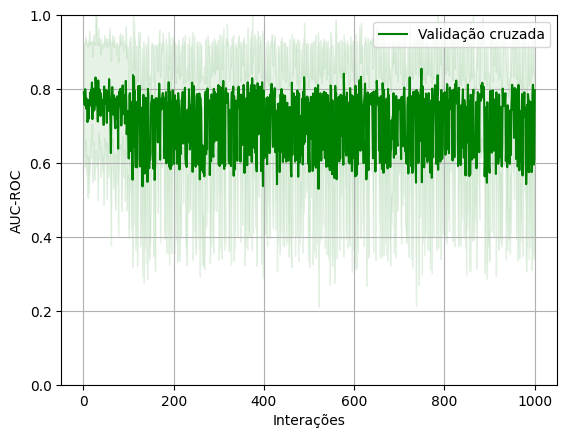

In [85]:
results_df_iforest2 = pd.read_csv('./metrics_anomaly_detection/results_df_iforest.csv')

results_df_iforest2  = results_df_iforest2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_iforest2, title="iforest", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [ ]:
# IsolationForest(contamination=0.0002, max_features=0.94, max_samples=0.37,
#                 n_estimators=76, random_state=42)

In [396]:
results_df_iforest['roc_auc_adjusted'] = results_df_iforest['mean_test_roc_auc'] - results_df_iforest['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_iforest['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
# best_params = results_df_iforest.loc[999]
best_params = results_df_iforest.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'n_estimators': 79.13278198242188, 'contamination': 0.0005663298652507365, 'max_samples': 0.31376564502716064, 'max_features': 0.9999392628669739}

Métricas: params                   {'n_estimators': 79.13278198242188, 'contamina...
fold_scores              {'f1_score': [0.32768924302788843, 0.317041296...
mean_test_f1_score                                                0.528524
std_test_f1_score                                                 0.291585
mean_test_specificity                                             0.649249
std_test_specificity                                              0.277828
mean_test_precision                                               0.440452
std_test_precision                                                0.339527
mean_test_recall                                                  0.889415
std_test_recall                                                   0.119092
mean_test_roc_auc                

In [316]:
# best_params_idx 

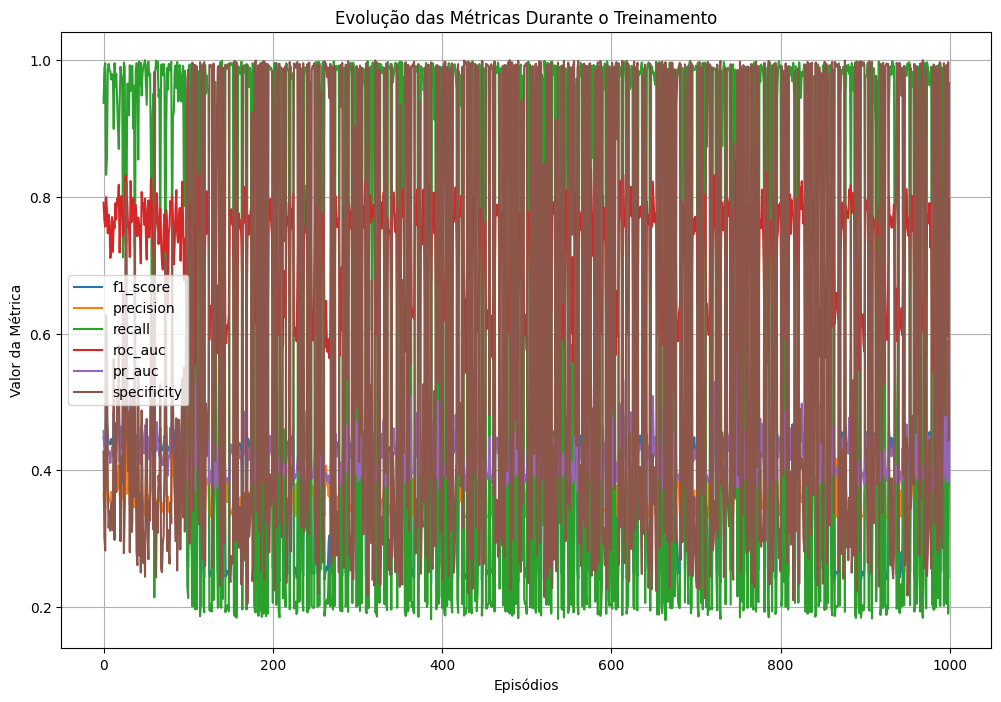

In [ ]:

plot_metrics(env.metrics_history)


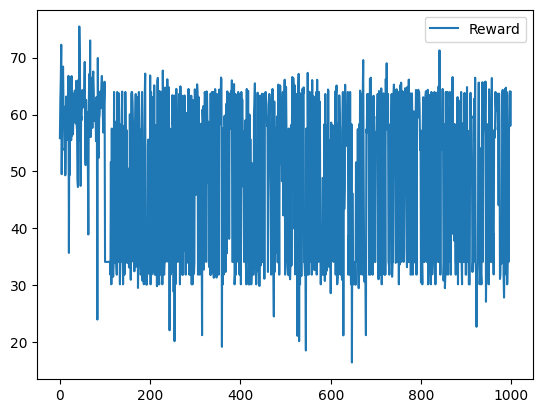

In [26]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

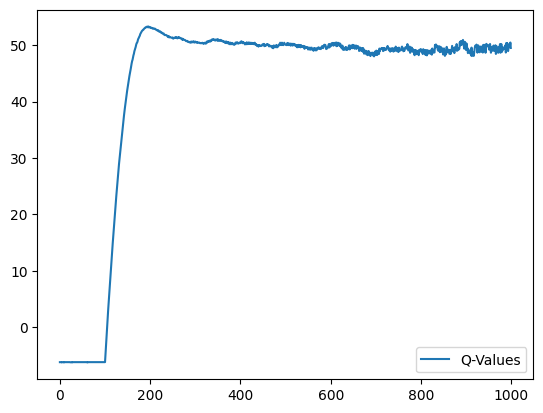

In [27]:
plt.plot(callback.q_values_history, label="Q-Values")
plt.legend()
plt.show()

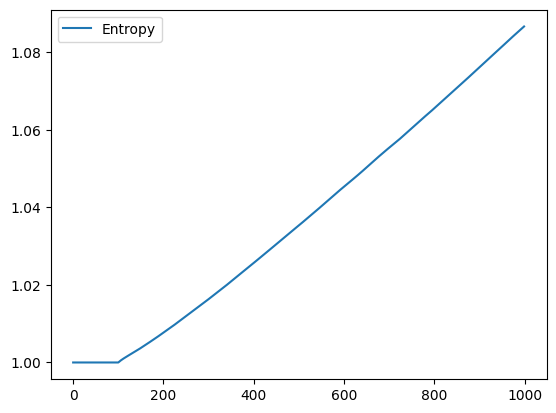

In [366]:
plt.plot(callback.entropy_history, label="Entropy")
plt.legend()
plt.show()

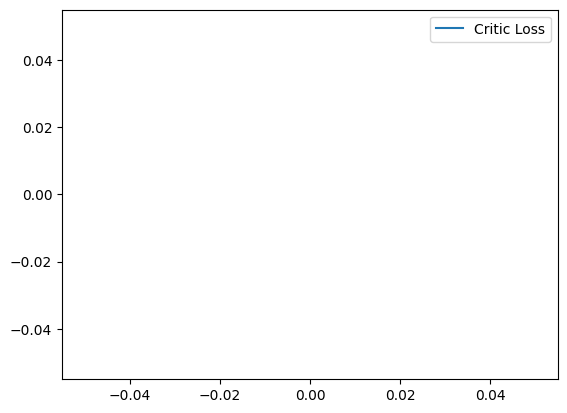

In [198]:
plt.plot(callback.critic_loss_history, label="Critic Loss")
plt.legend()
plt.show()

In [397]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_iforest.csv', index=False)
pd.DataFrame(callback.q_values_history).to_csv('./metrics_anomaly_detection/q_values_history_iforest.csv', index=False)
pd.DataFrame(callback.entropy_history).to_csv('./metrics_anomaly_detection/entropy_history_iforest.csv', index=False)

In [398]:
best_params['params']

{'n_estimators': 79.13278198242188,
 'contamination': 0.0005663298652507365,
 'max_samples': 0.31376564502716064,
 'max_features': 0.9999392628669739}

In [399]:
n_estimators_best = int(best_params['params'].get('n_estimators'))
contamination_best = round(float(best_params['params'].get('contamination')), 5)
max_samples_best = round(float(best_params['params'].get('max_samples')), 2)
max_features_best = round(float(best_params['params'].get('max_features')), 2)
bootstrap_best = bool(best_params['params'].get('bootstrap'))

print(f"Melhores hiperparâmetros encontrados: n_estimators={n_estimators_best}, contamination={contamination_best}, "
      f"max_samples={max_samples_best}, max_features={max_features_best}, bootstrap={bootstrap_best}")

Melhores hiperparâmetros encontrados: n_estimators=79, contamination=0.00057, max_samples=0.31, max_features=1.0, bootstrap=False


In [400]:
# IsolationForest(contamination=0.0002, max_features=0.94, max_samples=0.37,
#                 n_estimators=76, random_state=42)

# n_estimators_best= 76
# contamination_best = 0.0002
# max_samples_best = 0.37
# max_features_best = 0.94

In [401]:
estimator  = IsolationForest(
    n_estimators=n_estimators_best,
    contamination=contamination_best,
    max_samples=max_samples_best,
    max_features=max_features_best,
    bootstrap=bootstrap_best,
    random_state=42
)

# estimator = IsolationForest(random_state=42, **best_params['params'])
# estimator = IsolationForest(random_state=42, **best_params2)

best_model_iforest = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator)
        ])

best_model_iforest.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 IsolationForest(contamination=0.00057, max_samples=0.31,
                                 n_estimators=79, random_state=42))])

In [402]:
# def find_optimal_threshold(y_true, y_scores, metric='f1'):
#     precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
#     try:
#         f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
#     except:
#             f1_scores = 0    
#     best_idx = np.argmax(f1_scores)
#     return thresholds[best_idx], f1_scores[best_idx]

def find_optimal_threshold(y_true, y_scores):  
    # Calcula a curva ROC  
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)  
    
    # Calcula a AUC  
    roc_auc = auc(fpr, tpr)  

    # Calcula o ponto ótimo com base na distância euclidiana  
    optimal_idx = np.argmax(tpr - fpr)  # ou você pode usar outra abordagem  

    return thresholds[optimal_idx], roc_auc

In [403]:
scores_dev = -best_model_iforest.decision_function(X_dev)
final_auc = roc_auc_score(y_dev, scores_dev)
# Calcular a curva ROC  
fpr, tpr, thresholds = roc_curve(y_dev, scores_dev)  

print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9910


Melhor Threshold:  -0.07931887800540005


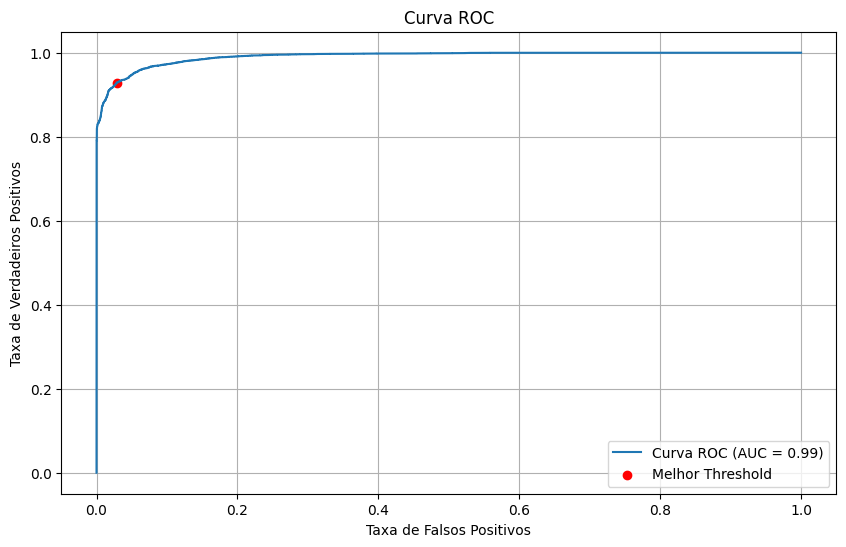

In [404]:
roc_auc = auc(fpr, tpr)  

# Encontrar o melhor threshold  
# Usando o ponto mais próximo do canto superior esquerdo (0,1)  
optimal_idx = np.argmax(tpr - fpr)  
best_threshold = thresholds[optimal_idx]  

print("Melhor Threshold: ", best_threshold)  

# Plotar a curva ROC  
plt.figure(figsize=(10, 6))  
plt.plot(fpr, tpr, label='Curva ROC (AUC = {:.2f})'.format(roc_auc))  
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', label='Melhor Threshold')  
plt.xlabel('Taxa de Falsos Positivos')  
plt.ylabel('Taxa de Verdadeiros Positivos')  
plt.title('Curva ROC')  
plt.legend()  
plt.grid()  
plt.show()  

In [405]:
# best_threshold, best_f1 = find_optimal_threshold(y_dev, scores_dev)


# y_pred = (scores_dev >= best_threshold).astype(int)
# print("Melhore threshold: ", best_threshold)

y_pred = best_model_iforest.predict(X_dev)
y_pred = np.where(y_pred == -1, 1, 0)  

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.91814   0.99941   0.95705     22051
         1.0    0.99855   0.81951   0.90021     10887

    accuracy                        0.93995     32938
   macro avg    0.95834   0.90946   0.92863     32938
weighted avg    0.94471   0.93995   0.93826     32938

Specificity: 0.9994104575756202
Gini:  0.8189199643267913
ROC AUC::  0.9094599821633956


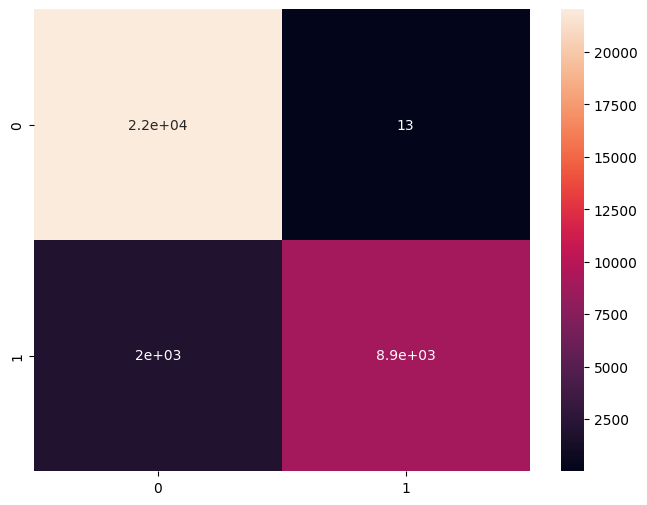

In [406]:
metrics(y_dev, y_pred)

In [407]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [408]:
# scores_valid = -best_model_iforest.decision_function(X_valid)
# y_pred = (scores_valid >= best_threshold).astype(int)
y_pred = best_model_iforest.predict(X_valid)
y_pred = np.where(y_pred == -1, 1, 0)  

In [409]:
scores_valid = -best_model_iforest.decision_function(X_valid)
final_auc = roc_auc_score(y_valid, scores_valid)
# Calcular a curva ROC  
fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9938


Classification Report: 
               precision    recall  f1-score   support

         0.0    0.99479   0.96513   0.97973      5936
         1.0    0.91660   0.98698   0.95049      2305

    accuracy                        0.97124      8241
   macro avg    0.95570   0.97606   0.96511      8241
weighted avg    0.97292   0.97124   0.97156      8241

Specificity: 0.9651280323450134
Gini:  0.9521128479632346
ROC AUC::  0.9760564239816173


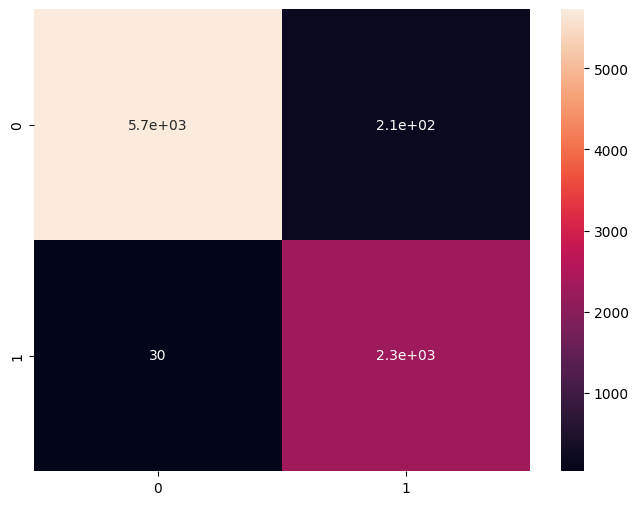

In [410]:
metrics(y_valid, y_pred)

In [411]:
scores = -best_model_iforest.decision_function(X_valid)
final_auc = roc_auc_score(y_valid, scores)

print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9938


In [412]:
validation['scores_forest']=-best_model_iforest.decision_function(X_valid)

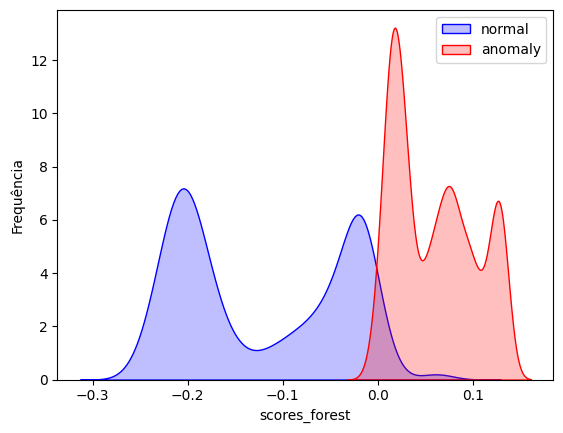

In [413]:
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 0) & (validation["scores_forest"].notnull())], color="Blue", fill = True)
g = sns.kdeplot(validation["scores_forest"][(validation["target"] == 1) & (validation["scores_forest"].notnull())], color="Red", fill = True)

g.set_xlabel("scores_forest")
g.set_ylabel("Frequência")
g = g.legend(['normal', 'anomaly'])

In [414]:
with open('./models/pipeline_iForest_RL.pkl', 'wb') as file: 
    pickle.dump(best_model_iforest, file)

In [415]:
# with open('./models/pipeline_iForest_RL.pkl', 'rb') as f:
#     iforest_old = pickle.load(f) 

# iforest_old

## Local Outlier Factor

In [51]:
from sklearn.neighbors import LocalOutlierFactor

In [52]:
def lof_factory(**params):
    return LocalOutlierFactor(
        n_neighbors=int(params['n_neighbors']),
        contamination=params['contamination'],
        novelty=True,
        n_jobs=-1
    )

param_ranges_lof = {
    'n_neighbors': (3, 25),
    'contamination': (0.0001, 0.005)
}

In [53]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env_lof = AnomalyDetectionEnv(X_dev, y_dev, tscv, feature_model, lof_factory, param_ranges_lof)

# Modelo SAC
model_lof_sac = SAC(
    "MlpPolicy",
    env_lof,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

# Treinamento do agente
callback = SACMetricsCallback()
model_lof_sac.learn(total_timesteps=1000, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 61       |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 29       |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 61.5     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 52       |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 61.5     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [54]:

results_df_lof = env_lof.get_results_table()
results_df_lof.head()

,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'n_neighbors': 10.998056411743164, 'contamina...","{'f1_score': [0.1049482163406214, 0.2981246218...",0.462960,0.378027,0.373042,0.412266,0.400856,0.406820,1.000000,0.000000,0.792800,0.177249,0.563316,0.342072,1.054756,0.764234,1.326383,0.673921
1,"{'n_neighbors': 23.33647918701172, 'contaminat...","{'f1_score': [0.1049482163406214, 0.2981246218...",0.465386,0.381382,0.382174,0.424999,0.405667,0.413575,0.999937,0.000089,0.780626,0.177513,0.535752,0.347571,1.055511,0.731248,1.507085,0.757870
2,"{'n_neighbors': 13.473114013671875, 'contamina...","{'f1_score': [0.10549501507071644, 0.298124621...",0.459493,0.372807,0.392408,0.433107,0.409828,0.419185,0.983336,0.022034,0.789765,0.177251,0.569169,0.341705,0.924671,0.717145,1.463473,0.764450
3,"{'n_neighbors': 11.087393760681152, 'contamina...","{'f1_score': [0.10827947811242532, 0.298124621...",0.416993,0.312122,0.410379,0.418141,0.410406,0.418771,0.901779,0.120776,0.785073,0.176741,0.557864,0.342842,0.996107,0.815844,1.345359,0.791802
4,"{'n_neighbors': 7.262989521026611, 'contaminat...","{'f1_score': [0.1049482163406214, 0.2981246218...",0.463877,0.379295,0.376466,0.417040,0.402644,0.409330,1.000000,0.000000,0.803727,0.179319,0.575369,0.340990,1.008627,0.598878,1.204306,0.394862


In [55]:
results_df_lof.to_csv('./metrics_anomaly_detection/results_df_lof.csv', index=False)

In [56]:

results_df_lof['roc_auc_adjusted'] = results_df_lof['mean_test_roc_auc'] - results_df_lof['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_lof['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_lof.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 



Melhores parâmetros encontrados (máxima média ajustada): {'n_neighbors': 3.259904623031616, 'contamination': 0.004958956968039274}

Métricas: params                   {'n_neighbors': 3.259904623031616, 'contaminat...
fold_scores              {'f1_score': [0.10497237569060773, 0.298124621...
mean_test_f1_score                                                0.451553
std_test_f1_score                                                 0.362247
mean_test_specificity                                             0.328835
std_test_specificity                                              0.350619
mean_test_precision                                               0.379389
std_test_precision                                                0.376689
mean_test_recall                                                       1.0
std_test_recall                                                        0.0
mean_test_roc_auc                                                    0.814
std_test_roc_auc                

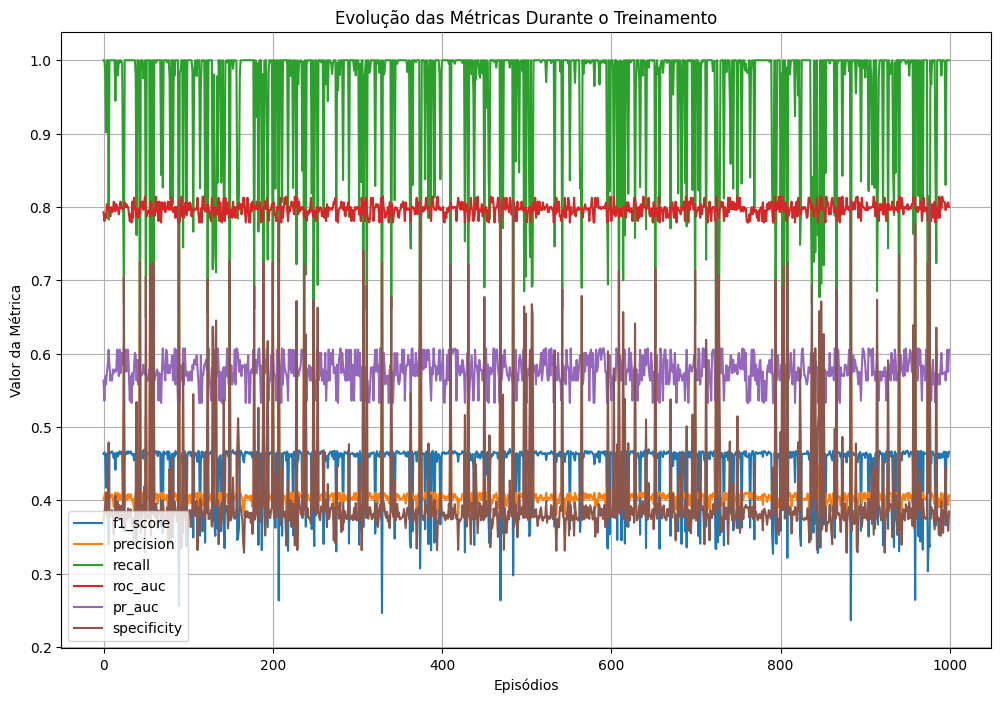

In [59]:
plot_metrics(env_lof.metrics_history)

In [454]:
# def plot_metrics_reward(metrics_history):
#     plt.figure(figsize=(12, 8))
#     plt.plot(metrics_history, label="Reward")
#     plt.xlabel('Episódios')
#     plt.ylabel('Valor da Métrica')
#     plt.title('Evolução das Métricas Durante o Treinamento')
#     plt.legend()
#     plt.grid()
#     plt.ylim(0, 1)
#     plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PHD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

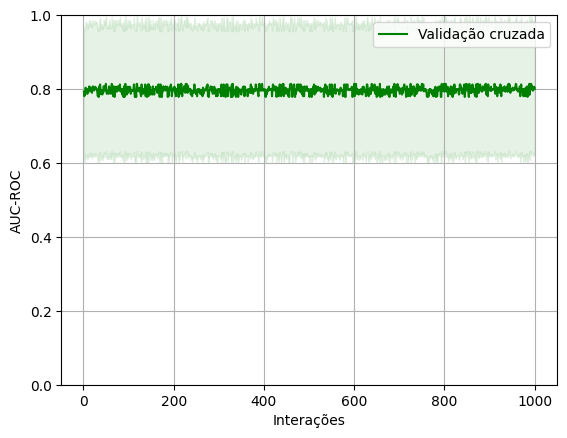

In [86]:
results_df_lof2 = pd.read_csv('./metrics_anomaly_detection/results_df_lof.csv')

results_df_lof2  = results_df_lof2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_lof2, title="LOF", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [458]:
# plot_metrics_reward(callback.rewards_history)

In [60]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_lof.csv', index=False)
pd.DataFrame(callback.q_values_history).to_csv('./metrics_anomaly_detection/q_values_history_lof.csv', index=False)
pd.DataFrame(callback.entropy_history).to_csv('./metrics_anomaly_detection/entropy_history_lof.csv', index=False)

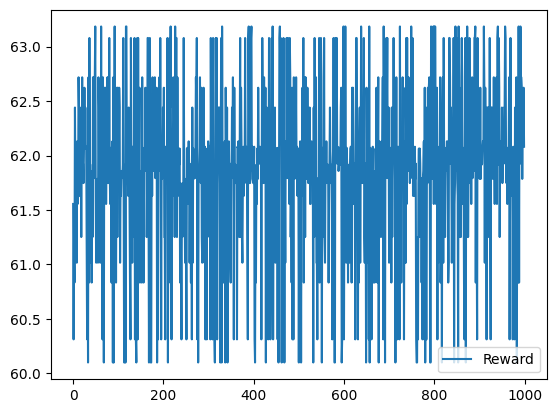

In [61]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

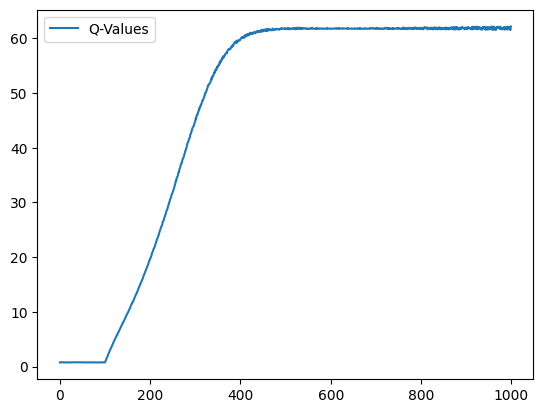

In [62]:
plt.plot(callback.q_values_history, label="Q-Values")
plt.legend()
plt.show()

In [63]:
best_params['params']

{'n_neighbors': 3.259904623031616, 'contamination': 0.004958956968039274}

In [ ]:
n_neighbors_best = int(round(best_params['params'].get('n_neighbors'), 0))
contamination_best = round(float(best_params['params'].get('contamination')), 5)

print(f"Melhores hiperparâmetros encontrados: n_neighbors={n_neighbors_best}, contamination={contamination_best}")

Melhores hiperparâmetros encontrados: n_neighbors=3, contamination=0.00496


In [24]:
estimator_lof  = LocalOutlierFactor(
    n_neighbors=n_neighbors_best,
    contamination=contamination_best,
    novelty=True,
    n_jobs=-1
)

In [25]:
best_model_lof = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)),
            ('estimator', estimator_lof)
        ])

In [26]:
best_model_lof.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 LocalOutlierFactor(contamination=0.00496, n_jobs=-1,
                                    n_neighbors=3, novelty=True))])

In [27]:
y_pred = best_model_lof.predict(X_dev)
y_pred = np.where(y_pred == -1, 1, 0)  

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.94644   0.99769   0.97139     22051
         1.0    0.99474   0.88564   0.93703     10887

    accuracy                        0.96065     32938
   macro avg    0.97059   0.94167   0.95421     32938
weighted avg    0.96240   0.96065   0.96003     32938

Specificity: 0.9976871797197406
Gini:  0.8833306076613225
ROC AUC::  0.9416653038306613


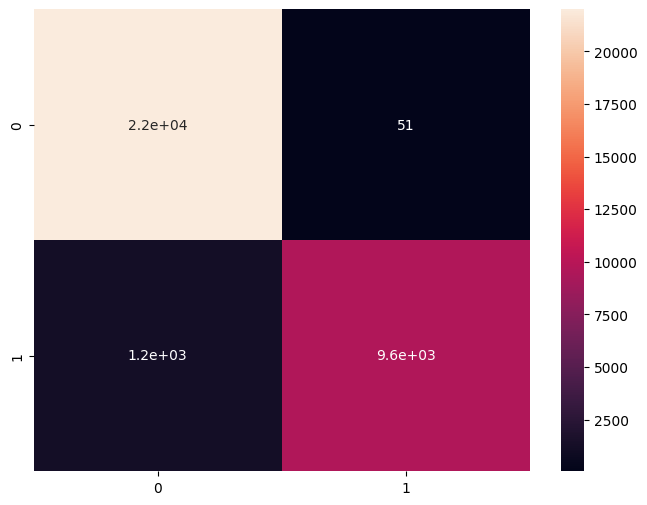

In [28]:
metrics(y_dev, y_pred)

In [29]:
X_valid = validation[feature_model].values
y_valid = validation['target'].values

In [30]:
y_pred = best_model_lof.predict(X_valid)
y_pred = np.where(y_pred == -1, 1, 0)  

In [31]:

scores_valid = -best_model_lof.decision_function(X_valid)
final_auc = roc_auc_score(y_valid, scores_valid)
# Calcular a curva ROC  
fpr, tpr, thresholds = roc_curve(y_valid, scores_valid)  

print(f"AUC final com melhores hiperparâmetros: {final_auc:.4f}")

AUC final com melhores hiperparâmetros: 0.9958


Classification Report: 
               precision    recall  f1-score   support

         0.0    1.00000   0.96597   0.98269      5936
         1.0    0.91943   1.00000   0.95802      2305

    accuracy                        0.97549      8241
   macro avg    0.95971   0.98299   0.97036      8241
weighted avg    0.97746   0.97549   0.97579      8241

Specificity: 0.9659703504043127
Gini:  0.9659703504043127
ROC AUC::  0.9829851752021563


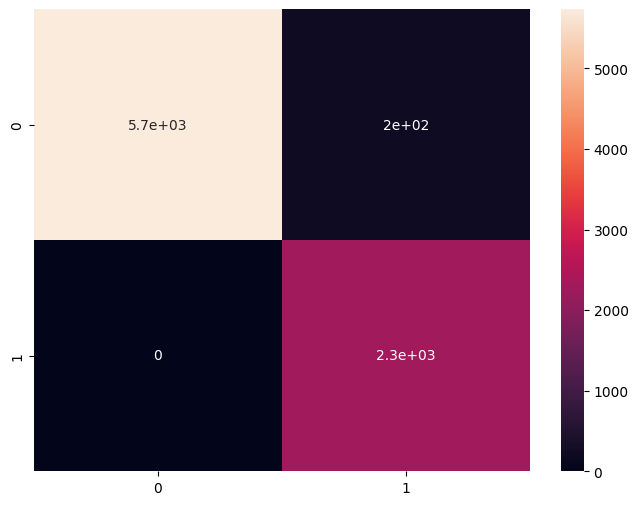

In [32]:
metrics(y_valid, y_pred)

In [33]:
with open('./models/pipeline_LOF_RL.pkl', 'wb') as file: 
    pickle.dump(best_model_lof, file)

In [474]:
# with open('./models/pipeline_LOF_RL_old.pkl', 'rb') as f:
#     lof_old = pickle.load(f) 

# lof_old

## Algorithms Pyod
https://pyod.readthedocs.io/en/latest/

In [25]:
import numpy as np
import gym
from gym import spaces
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, confusion_matrix, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import time

class AnomalyDetectionEnv_Pyod(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior e superior para cada hiperparâmetro
        """
        super(AnomalyDetectionEnv_Pyod, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Espaço de ação baseado nos hiperparâmetros
        low_bounds = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)
        high_bounds = np.array([param_ranges[p][1] for p in param_ranges], dtype=np.float32)
        self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Espaço de observação (hiperparâmetros atuais)
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Estado inicial: média dos limites dos hiperparâmetros
        # self.state = np.array([(param_ranges[p][0] + param_ranges[p][1]) / 2 for p in param_ranges], dtype=np.float32)
        self.state = np.array([param_ranges[p][0] for p in param_ranges], dtype=np.float32)

        # Histórico de métricas
        self.metrics_history = {
            'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': []
        }

        self.rewards_history = []  # Histórico de recompensas
        self.q_values_history = []  # Histórico de Q-values
        self.entropy_history = []  # Histórico de entropia
        self.critic_loss_history = []  # Histórico de critic loss

        # Lista para armazenar os resultados detalhados de cada rodada
        self.results = []

    def find_optimal_threshold(self, y_true, y_scores, metric='f1'):
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
        try:
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        except:
              f1_scores = 0    
        best_idx = np.argmax(f1_scores)
        return thresholds[best_idx], f1_scores[best_idx]

    def step(self, action):
        # Verificar se a ação contém valores inválidos
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        # Criar dicionário de hiperparâmetros ajustados dentro dos limites
        params = {key: np.clip(action[i], *self.param_ranges[key]) for i, key in enumerate(self.param_ranges)}

        # Criar o modelo com os hiperparâmetros escolhidos
        model = self.model_factory(**params)

        # Pipeline de pré-processamento e modelo
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('model', model)
        ])

        # Validação cruzada e avaliação do modelo
        split_scores = {
            'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': [], 'fit_time': [], 'score_time': []
        }

        for train_index, test_index in self.tscv.split(self.X):
            # Filtrar apenas eventos normais no conjunto de treinamento
            X_train_split = self.X[train_index][self.y[train_index] == 0]

            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            start_fit = time.time()
            pipeline.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = pipeline.decision_function(X_test_split) if hasattr(pipeline, "decision_function") else pipeline.predict_proba(X_test_split)[:, 1]
            y_pred = pipeline.predict(X_test_split)
            score_time = time.time() - start_score

            # Mapear previsões para anomalias (0 = normal, 1 = anomalia)
            # y_pred = np.where(y_pred == -1, 1, 0)
            # best_threshold, best_f1 = self.find_optimal_threshold(y_test_split, y_scores)
            # y_pred = (y_scores >= best_threshold).astype(int)

            # Calcular métricas
            precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
            roc_auc = roc_auc_score(y_test_split, y_scores)
            # try:
            #     roc_auc = roc_auc_score(y_test_split, y_pred)
            # except:
                # roc_auc=0    
            pr_auc = average_precision_score(y_test_split, y_scores)      

            # Calcular especificidade
            tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            split_scores['f1_score'].append(f1)
            split_scores['precision'].append(precision)
            split_scores['recall'].append(recall)
            split_scores['roc_auc'].append(roc_auc)
            split_scores['pr_auc'].append(pr_auc)
            split_scores['specificity'].append(specificity)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        # Adicionar resultados detalhados
        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            "mean_test_f1_score": np.mean(split_scores['f1_score']),
            "std_test_f1_score": np.std(split_scores['f1_score']),
            "mean_test_specificity": np.mean(split_scores['specificity']),
            "std_test_specificity": np.std(split_scores['specificity']),
            "mean_test_precision": np.mean(split_scores['precision']),
            "std_test_precision": np.std(split_scores['precision']),
            "mean_test_recall": np.mean(split_scores['recall']),
            "std_test_recall": np.std(split_scores['recall']),
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            "mean_test_pr_auc": np.mean(split_scores['pr_auc']),
            "std_test_pr_auc": np.std(split_scores['pr_auc']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        # Recompensa baseada no AUC-ROC médio
        # reward = 1*(np.mean(split_scores['roc_auc']))

        # reward = 2 * np.mean(split_scores['roc_auc']) - 1
        reward = 100*(np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))

        # reward = np.mean(split_scores['f1_score'])
        # reward = np.mean(split_scores['pr_auc'])

        self.rewards_history.append(reward)

        # Atualizar histórico de métricas
        for metric in self.metrics_history:
            self.metrics_history[metric].append(np.mean(split_scores[metric]))

        # Atualizar estado
        self.state = np.array(list(params.values()), dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([(self.param_ranges[p][0] + self.param_ranges[p][1]) / 2 for p in self.param_ranges], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        """ Retorna um DataFrame com os resultados da validação cruzada. """
        return pd.DataFrame(self.results)

#### PCA

In [29]:
def pca_factory(**params):
    return PCA(
        contamination=params['contamination'],
        n_components=params['n_components']
    )

n_comp = train.shape[1]-1

param_ranges_pca = {
    'contamination': (0.0001, 0.005),
    'n_components': (0.5, 1)
}

In [30]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_Pyod(X_dev, y_dev, tscv, feature_model, pca_factory, param_ranges_pca)

# Modelo SAC
model_pca_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

# Treinamento do agente
callback = SACMetricsCallback()
model_pca_sac.learn(total_timesteps=1000, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 59.9     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 60       |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 60.2     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [50]:
results_df_pca = env.get_results_table()
results_df_pca.head()

,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'contamination': 0.0045011877082288265, 'n_co...","{'f1_score': [0.15469613259668508, 0.381129156...",0.486342,0.322441,0.807602,0.268011,0.572729,0.318552,0.649821,0.398641,0.759195,0.157334,0.521024,0.342645,0.258602,0.228983,0.008643,0.000940
1,"{'contamination': 0.002079433063045144, 'n_com...","{'f1_score': [0.1338432122370937, 0.3811291569...",0.479464,0.329758,0.808159,0.268400,0.585939,0.315353,0.644830,0.405867,0.756074,0.157461,0.512111,0.345600,0.031819,0.009333,0.009971,0.001410
2,"{'contamination': 0.002735292073339224, 'n_com...","{'f1_score': [0.13909774436090225, 0.381129156...",0.481143,0.327828,0.807859,0.268190,0.574090,0.318173,0.646166,0.403755,0.759195,0.157334,0.521024,0.342645,0.073590,0.029958,0.008311,0.001880
3,"{'contamination': 0.0002904325083363801, 'n_co...","{'f1_score': [0.0875, 0.3811291569992266, 0.90...",0.459153,0.339815,0.809402,0.269274,0.703476,0.334871,0.626316,0.415941,0.759195,0.157333,0.521024,0.342644,0.238208,0.160705,0.011961,0.002827
4,"{'contamination': 0.001634997664950788, 'n_com...","{'f1_score': [0.1343570057581574, 0.3811291569...",0.478065,0.327465,0.808245,0.268460,0.591297,0.314363,0.642132,0.404468,0.756054,0.157485,0.512106,0.345605,0.082016,0.014442,0.009849,0.000970


In [51]:
results_df_pca.to_csv('./metrics_anomaly_detection/results_df_pca.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PHD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

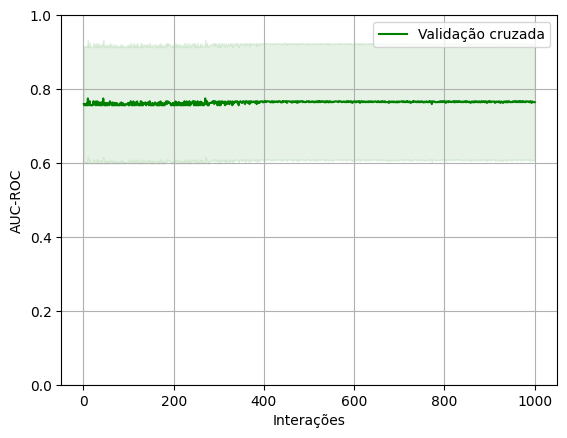

In [87]:
results_df_pca2 = pd.read_csv('./metrics_anomaly_detection/results_df_pca.csv')

results_df_pca2  = results_df_pca2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_pca2, title="pca", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [52]:
results_df_pca['roc_auc_adjusted'] = results_df_pca['mean_test_roc_auc'] - results_df_pca['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_pca['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_pca.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'contamination': 0.0014744423096999526, 'n_components': 0.5086707472801208}

Métricas: params                   {'contamination': 0.0014744423096999526, 'n_co...
fold_scores              {'f1_score': [0.2517985611510791, 0.3811291569...
mean_test_f1_score                                                0.517213
std_test_f1_score                                                 0.288769
mean_test_specificity                                             0.808245
std_test_specificity                                               0.26846
mean_test_precision                                               0.645143
std_test_precision                                                0.314536
mean_test_recall                                                  0.667717
std_test_recall                                                   0.368745
mean_test_roc_auc                                                 0.774507
std_test_roc_auc             

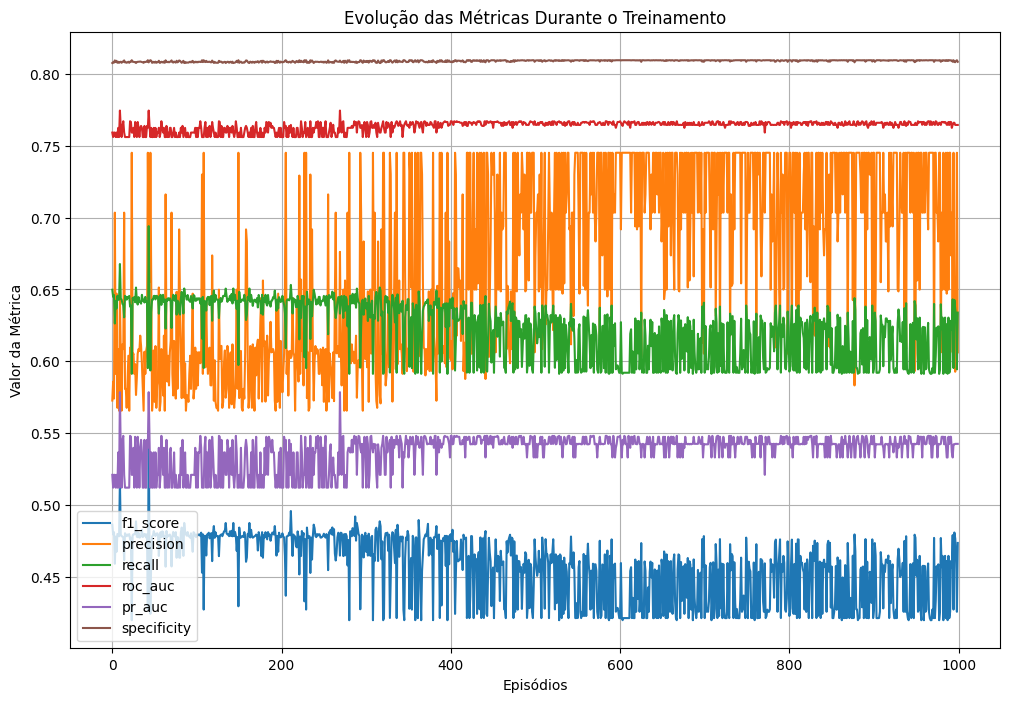

In [53]:
plot_metrics(env.metrics_history)

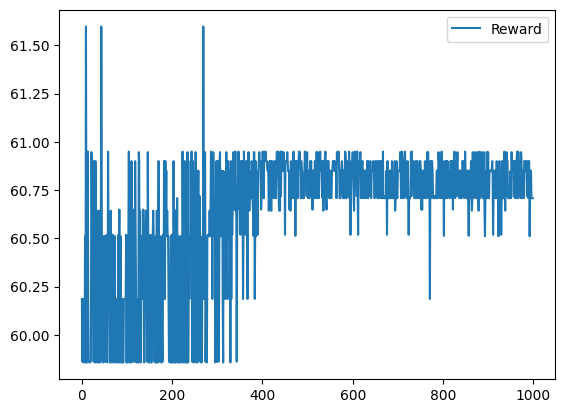

In [54]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()

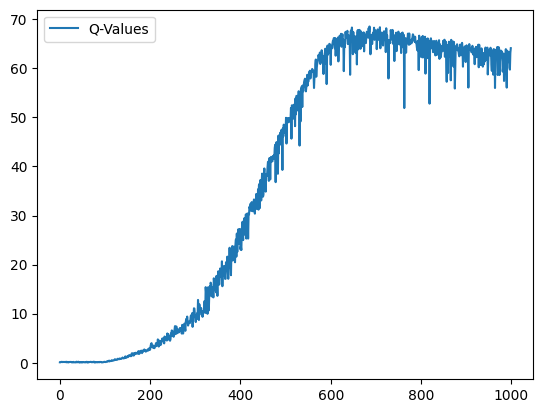

In [55]:
plt.plot(callback.q_values_history, label="Q-Values")
plt.legend()
plt.show()

In [31]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_pca.csv', index=False)
pd.DataFrame(callback.q_values_history).to_csv('./metrics_anomaly_detection/q_values_history_pca.csv', index=False)
pd.DataFrame(callback.entropy_history).to_csv('./metrics_anomaly_detection/entropy_history_pca.csv', index=False)

In [56]:
best_params['params']

{'contamination': 0.0014744423096999526, 'n_components': 0.5086707472801208}

In [ ]:

contamination_best = round(float(best_params['params'].get('contamination')), 5)
n_components_best = round(float(best_params['params'].get('n_components')), 2)


print(f"Melhores hiperparâmetros encontrados: contamination={contamination_best}, "
      f"n_components={n_components_best}")

Melhores hiperparâmetros encontrados: contamination=0.00147, n_components=0.51


In [36]:
estimator = PCA(random_state=42, 
                contamination = contamination_best,
                n_components = n_components_best
                
                )

best_model_pca = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

best_model_pca.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 PCA(contamination=0.00147, copy=True, iterated_power='auto',
  n_components=0.51, n_selected_components=None, random_state=42,
  standardization=True, svd_solver='auto', tol=0.0, weighted=True,
  whiten=False))])

In [37]:
scale_pca = best_model_pca[0]

In [38]:
media = scale_pca.mean_

desvio_padrao = scale_pca.scale_

print("Média calculada pelo StandardScaler:", media)
print("Desvio padrão calculado pelo StandardScaler:", desvio_padrao)

Média calculada pelo StandardScaler: [8.91085176e+06 8.06743508e+04 8.75836601e+06 9.03066741e+06
 1.40254922e+07 4.61291442e+03 1.40174804e+07 1.40335326e+07
 1.16045582e+02 1.18593138e-02 1.16024804e+02 1.16066501e+02
 5.24392488e+06 9.67326189e+04 5.06198619e+06 5.46269603e+06
 7.25576971e+01 1.86427312e-01 7.21970287e+01 7.29420364e+01
 1.82634081e+08 8.35549961e+04 1.82462940e+08 1.82803085e+08]
Desvio padrão calculado pelo StandardScaler: [1.79080905e+07 1.02369711e+06 1.78742195e+07 1.80627975e+07
 5.36383406e+06 4.78282158e+03 5.36560334e+06 5.36186551e+06
 3.62810319e+00 1.59484150e-02 3.63002129e+00 3.62624100e+00
 4.29682316e+06 1.05462642e+05 4.43557903e+06 4.13154923e+06
 1.11973261e+01 1.98474458e-01 1.11553280e+01 1.12583603e+01
 5.23480563e+08 3.12831429e+05 5.23093526e+08 5.23862984e+08]


In [39]:
y_pred = best_model_pca.predict(development[feature_model])

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.81882   0.99850   0.89978     22051
         1.0    0.99454   0.55249   0.71036     10887

    accuracy                        0.85108     32938
   macro avg    0.90668   0.77550   0.80507     32938
weighted avg    0.87690   0.85108   0.83717     32938

Specificity: 0.9985034692304204
Gini:  0.5509972691753091
ROC AUC::  0.7754986345876546


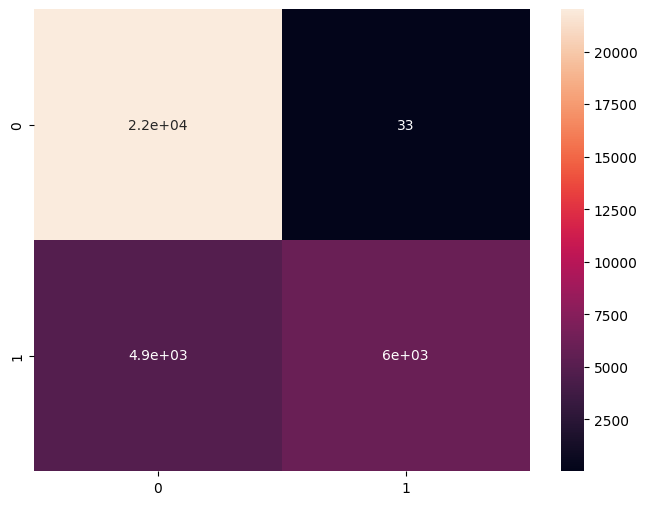

In [40]:
metrics(y_dev, y_pred)

In [41]:
y_pred = best_model_pca.predict(validation[feature_model])
y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.95243   0.99175   0.97169      5936
         1.0    0.97621   0.87245   0.92142      2305

    accuracy                        0.95838      8241
   macro avg    0.96432   0.93210   0.94656      8241
weighted avg    0.95909   0.95838   0.95763      8241

Specificity: 0.9917452830188679
Gini:  0.8641964760774361
ROC AUC::  0.932098238038718


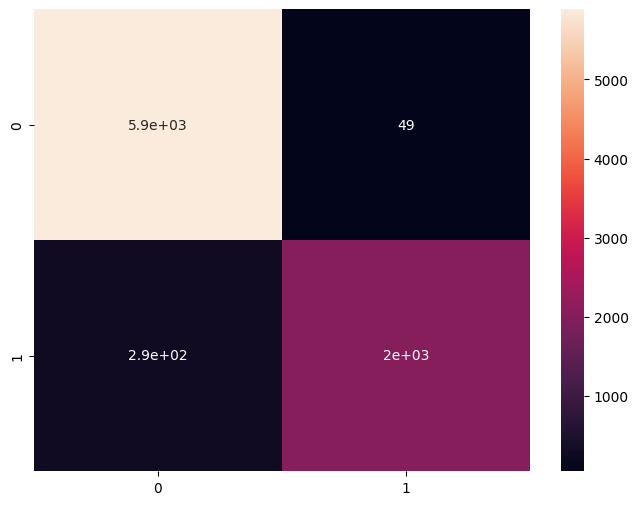

In [42]:
metrics(y_test, y_pred)

In [43]:
with open('./models/pipeline_PCA_RL.pkl', 'wb') as file: 
    pickle.dump(best_model_pca, file)

In [46]:
# with open('./models/pipeline_PCA_RL_old.pkl', 'rb') as f:
#     pca_old = pickle.load(f) 
# pca_old

#### LODA

In [26]:
def loda_factory(**params):
    return LODA(
        contamination=params['contamination'],
        n_bins=int(params['n_bins']),
        n_random_cuts=int(params['n_random_cuts'])
    )

param_ranges_loda = {
    'contamination': (0.0001, 0.005),
    'n_bins': (50, 5000),
    'n_random_cuts': (10, 1000)
}

In [27]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_Pyod(X_dev, y_dev, tscv, feature_model, loda_factory, param_ranges_loda)

# Modelo SAC
model_loda_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

# Treinamento do agente
callback = SACMetricsCallback()
model_loda_sac.learn(total_timesteps=1000, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 65.2     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 0        |
|    time_elapsed    | 18       |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 65.6     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 39       |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 66.1     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [44]:
results_df_loda = env.get_results_table()
results_df_loda.head()

,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'contamination': 0.003346635727211833, 'n_bin...","{'f1_score': [0.1049482163406214, 0.3470198675...",0.425678,0.299202,0.341171,0.300097,0.342688,0.275978,0.835543,0.215123,0.747322,0.058317,0.422418,0.313029,1.089648,0.512053,0.863239,0.298254
1,"{'contamination': 0.0006616777391172945, 'n_bi...","{'f1_score': [0.1049482163406214, 0.4267905157...",0.466228,0.312331,0.432168,0.310609,0.387981,0.310841,0.883422,0.125889,0.729744,0.094985,0.409248,0.352084,1.338274,0.513108,0.785815,0.087722
2,"{'contamination': 0.0005516003002412617, 'n_bi...","{'f1_score': [0.1049482163406214, 0.2796208530...",0.446081,0.365937,0.521002,0.382058,0.400483,0.391902,0.812561,0.236536,0.829723,0.140487,0.610712,0.289713,0.171969,0.068057,0.143721,0.022213
3,"{'contamination': 0.003879493335261941, 'n_bin...","{'f1_score': [0.1049482163406214, 0.4266931282...",0.451669,0.293824,0.314086,0.302728,0.354132,0.265148,0.899351,0.142340,0.669940,0.074585,0.362670,0.331601,1.023932,0.360188,0.674365,0.101240
4,"{'contamination': 0.00017821777146309614, 'n_b...","{'f1_score': [0.10496029462538842, 0.092475067...",0.309209,0.297723,0.477400,0.337565,0.311561,0.349440,0.597286,0.360996,0.675182,0.053940,0.355583,0.309039,1.018244,0.437773,0.765085,0.120437


In [45]:
results_df_loda.to_csv('./metrics_anomaly_detection/results_df_loda.csv', index=False)

<module 'matplotlib.pyplot' from 'c:\\Users\\User\\anaconda3\\envs\\PHD\\Lib\\site-packages\\matplotlib\\pyplot.py'>

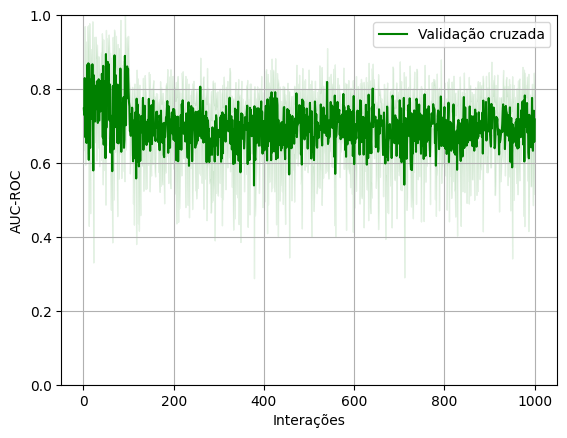

In [46]:
results_df_loda2 = pd.read_csv('./metrics_anomaly_detection/results_df_loda.csv')

results_df_loda2  = results_df_loda2[['mean_test_roc_auc', 'std_test_roc_auc']]

plot_learning_curve_cross_validation(results_df_loda2, title="loda", ylim=(0, 1), train_sizes=np.linspace(1, 1000, 1000))

In [34]:

results_df_loda['roc_auc_adjusted'] = results_df_loda['mean_test_roc_auc'] - results_df_loda['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_loda['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_loda.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'contamination': 0.002833013189956546, 'n_bins': 1472.42724609375, 'n_random_cuts': 433.4508361816406}

Métricas: params                   {'contamination': 0.002833013189956546, 'n_bin...
fold_scores              {'f1_score': [0.1049482163406214, 0.3051393188...
mean_test_f1_score                                                0.410442
std_test_f1_score                                                 0.301755
mean_test_specificity                                             0.135626
std_test_specificity                                              0.095981
mean_test_precision                                               0.310735
std_test_precision                                                0.277683
mean_test_recall                                                  0.999937
std_test_recall                                                   0.000089
mean_test_roc_auc                                                 0.891242
st

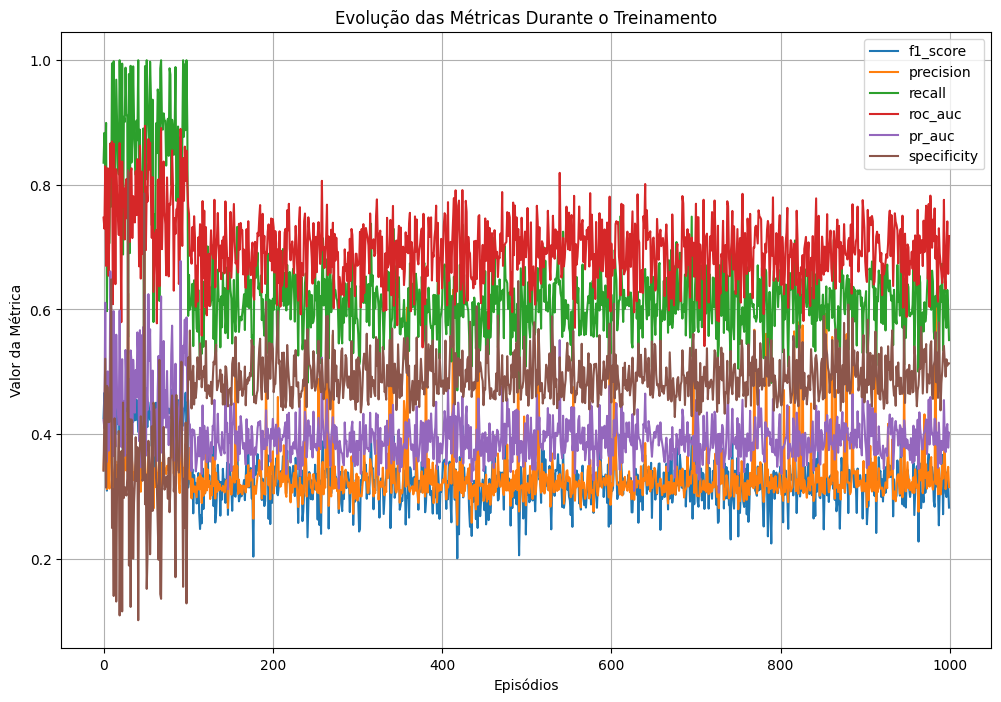

In [47]:
plot_metrics(env.metrics_history)

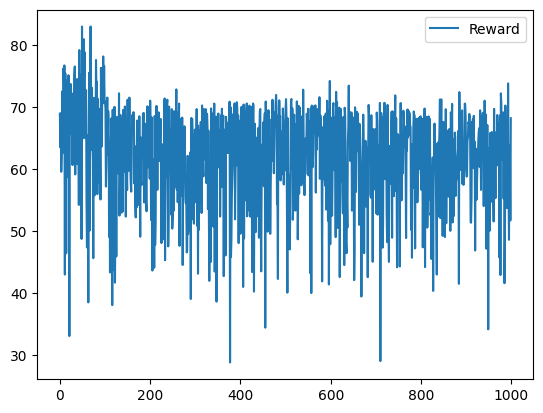

In [48]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()


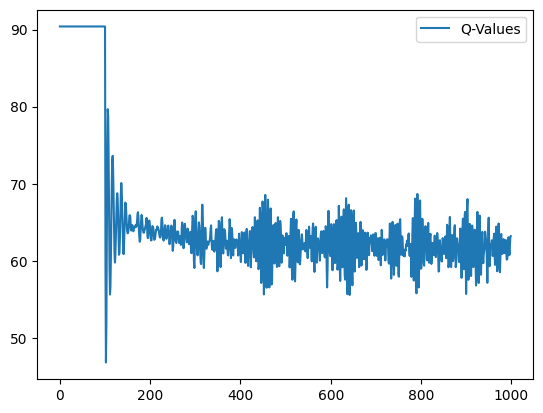

In [49]:
plt.plot(callback.q_values_history, label="Q-Values")
plt.legend()
plt.show()

In [31]:
pd.DataFrame(callback.rewards_history).to_csv('./metrics_anomaly_detection/rewards_history_loda.csv', index=False)
pd.DataFrame(callback.q_values_history).to_csv('./metrics_anomaly_detection/q_values_history_loda.csv', index=False)
pd.DataFrame(callback.entropy_history).to_csv('./metrics_anomaly_detection/entropy_history_loda.csv', index=False)

In [35]:
best_params['params']

{'contamination': 0.002833013189956546,
 'n_bins': 1472.42724609375,
 'n_random_cuts': 433.4508361816406}

In [36]:
n_random_cuts_best = int(best_params['params'].get('n_random_cuts'))
contamination_best = round(float(best_params['params'].get('contamination')), 5)
n_bins_best = int(best_params['params'].get('n_bins'))


print(f"Melhores hiperparâmetros encontrados: n_random_cuts={n_random_cuts_best}, contamination={contamination_best}, "
      f"n_bins={n_bins_best}")

Melhores hiperparâmetros encontrados: n_random_cuts=433, contamination=0.00283, n_bins=1472


In [37]:
estimator = LODA(contamination=contamination_best, n_bins=n_bins_best, n_random_cuts=n_random_cuts_best)

best_model_loda = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

best_model_loda.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 LODA(contamination=0.00283, n_bins=1472, n_random_cuts=433))])

In [38]:
y_pred = best_model_loda.predict(validation[feature_model])
y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.97638   0.94710   0.96152      5936
         1.0    0.87354   0.94100   0.90602      2305

    accuracy                        0.94539      8241
   macro avg    0.92496   0.94405   0.93377      8241
weighted avg    0.94762   0.94539   0.94599      8241

Specificity: 0.9471024258760108
Gini:  0.8881002566786138
ROC AUC::  0.9440501283393069


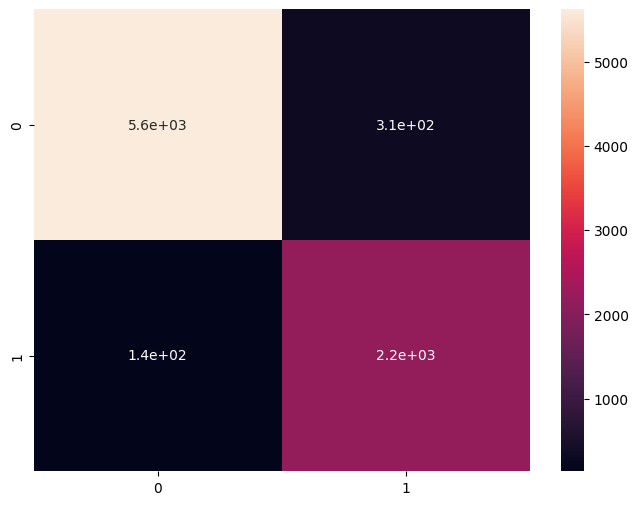

In [39]:
metrics(y_test, y_pred)

In [40]:
with open('./models/pipeline_LODA_RL.pkl', 'wb') as file: 
    pickle.dump(best_model_loda, file)

In [41]:
with open('./models/pipeline_LODA_RL_old.pkl', 'rb') as f:
    loda_old = pickle.load(f) 
loda_old

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 LODA(contamination=0.01, n_bins=623, n_random_cuts=27))])

In [42]:
y_pred = loda_old.predict(development[feature_model])

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.92874   0.98998   0.95838     22051
         1.0    0.97657   0.84615   0.90669     10887

    accuracy                        0.94244     32938
   macro avg    0.95266   0.91806   0.93254     32938
weighted avg    0.94455   0.94244   0.94130     32938

Specificity: 0.9899777787855426
Gini:  0.8361245593495179
ROC AUC::  0.918062279674759


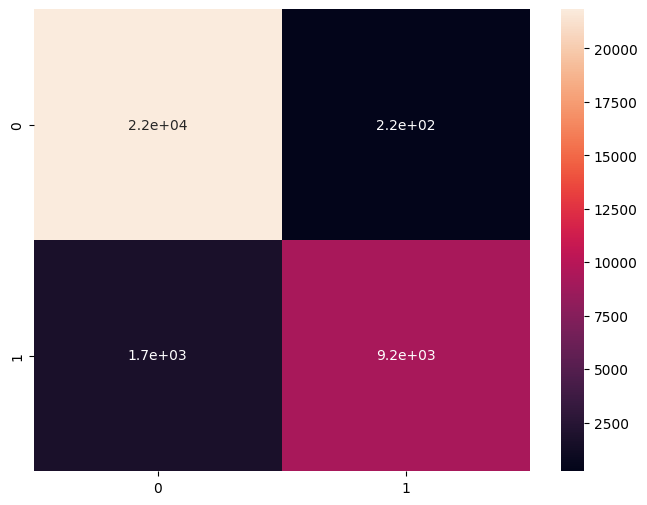

In [43]:
metrics(y_dev, y_pred)

### SGDOneClassSVM
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDOneClassSVM.html#sklearn.linear_model.SGDOneClassSVM

In [ ]:
# class AnomalyDetectionEnv(gym.Env):
#     def __init__(self, X, y, tscv, features, model_factory, param_ranges):
#         super(AnomalyDetectionEnv, self).__init__()

#         self.X = X
#         self.y = y
#         self.tscv = tscv
#         self.features = features
#         self.model_factory = model_factory
#         self.param_ranges = param_ranges

#         # Espaço de ação: 
#         # - nu, eta0 contínuos
#         # - learning_rate categórico
#         # - kernel e gamma para aproximação de kernel
#         low_bounds = np.array([
#             param_ranges['nu'][0], 
#             param_ranges['eta0'][0],
#             0,  # Índice para learning_rate
#             0,  # Índice para kernel_type
#             param_ranges['gamma'][0]
#         ], dtype=np.float32)
        
#         high_bounds = np.array([
#             param_ranges['nu'][1],
#             param_ranges['eta0'][1],
#             len(param_ranges['learning_rate']) - 1e-6,
#             len(param_ranges['kernel_type']) - 1e-6,
#             param_ranges['gamma'][1]
#         ], dtype=np.float32)
        
#         self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
#         self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

#         # Estado inicial
#         self.state = np.array([
#             np.mean(param_ranges['nu']),
#             np.mean(param_ranges['eta0']),
#             0,  # learning_rate index
#             0,  # kernel_type index
#             np.mean(param_ranges['gamma'])
#         ], dtype=np.float32)

#         # Históricos
#         self.metrics_history = {
#             'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': []
#         }
#         self.rewards_history = []
#         self.results = []

#     def find_optimal_threshold(self, y_true, y_scores):
#         precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
#         try:
#             f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
#         except:
#             f1_scores = 0    
#         best_idx = np.argmax(f1_scores)
#         return thresholds[best_idx], f1_scores[best_idx]

#     def step(self, action):
#         if np.isnan(action).any():
#             print("Ação inválida detectada:", action)
#             return self.reset(), 0, True, {"invalid_action": True}

#         # Processar ação para obter parâmetros
#         lr_idx = int(np.clip(action[2], 0, len(self.param_ranges['learning_rate']) - 1))
#         kernel_idx = int(np.clip(action[3], 0, len(self.param_ranges['kernel_type']) - 1))
        
#         params = {
#             'nu': np.clip(action[0], *self.param_ranges['nu']),
#             'eta0': np.clip(action[1], *self.param_ranges['eta0']),
#             'learning_rate': self.param_ranges['learning_rate'][lr_idx],
#             'kernel_type': self.param_ranges['kernel_type'][kernel_idx],
#             'gamma': np.clip(action[4], *self.param_ranges['gamma'])
#         }

#         # Criar o modelo com a pipeline apropriada
#         model = self.model_factory(**params)

#         # Validação cruzada e avaliação
#         split_scores = {
#             'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 
#             'specificity': [], 'fit_time': [], 'score_time': []
#         }

#         for train_index, test_index in self.tscv.split(self.X):
#             X_train_split = self.X[train_index][self.y[train_index] == 0]
#             X_test_split = self.X[test_index]
#             y_test_split = self.y[test_index]

#             start_fit = time.time()
#             model.fit(X_train_split)
#             fit_time = time.time() - start_fit

#             start_score = time.time()
#             y_scores = -model.decision_function(X_test_split)  # Scores de anomalia
#             y_pred = model.predict(X_test_split)
#             score_time = time.time() - start_score

#             # Converter previsões (-1=anomalia, 1=normal) para (1=anomalia, 0=normal)
#             y_pred = np.where(y_pred == -1, 1, 0)

#             # Calcular métricas
#             precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
#             recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
#             f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
#             roc_auc = roc_auc_score(y_test_split, y_scores)
#             pr_auc = average_precision_score(y_test_split, y_scores)      

#             # Especificidade
#             tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
#             specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

#             # Armazenar métricas
#             for metric in ['f1_score', 'precision', 'recall', 'roc_auc', 'pr_auc', 'specificity', 'fit_time', 'score_time']:
#                 split_scores[metric].append(locals()[metric])

#         # Armazenar resultados
#         self.results.append({
#             "params": params,
#             "fold_scores": split_scores,
#             **{f"mean_test_{k}": np.mean(v) for k, v in split_scores.items()},
#             **{f"std_test_{k}": np.std(v) for k, v in split_scores.items()}
#         })

#         # Recompensa baseada no ROC-AUC
#         # reward = 2 * np.mean(split_scores['roc_auc']) - 1
#         reward = 100*(np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))
#         self.rewards_history.append(reward)

#         # Atualizar histórico de métricas
#         for metric in self.metrics_history:
#             self.metrics_history[metric].append(np.mean(split_scores[metric]))

#         # Atualizar estado
#         self.state = np.array([
#             params['nu'],
#             params['eta0'],
#             lr_idx,
#             kernel_idx,
#             params['gamma']
#         ], dtype=np.float32)

#         return self.state, reward, True, {}

#     def reset(self):
#         self.state = np.array([
#             np.mean(self.param_ranges['nu']),
#             np.mean(self.param_ranges['eta0']),
#             0,  # learning_rate index
#             0,  # kernel_type index
#             np.mean(self.param_ranges['gamma'])
#         ], dtype=np.float32)
#         return self.state

#     def render(self, mode='human'):
#         pass

#     def get_results_table(self):
#         return pd.DataFrame(self.results)

In [506]:
class AnomalyDetectionEnv_SVM(gym.Env):
    def __init__(self, X, y, tscv, features, model_factory, param_ranges):
        """
        Ambiente de RL para otimização de modelos de detecção de anomalias.

        :param X: Dados de entrada (numpy array)
        :param y: Rótulos (numpy array)
        :param tscv: TimeSeriesSplit para validação cruzada
        :param features: Lista de features usadas
        :param model_factory: Função que recebe um conjunto de hiperparâmetros e retorna um modelo
        :param param_ranges: Dicionário com limites inferior e superior para cada hiperparâmetro
        """
        super(AnomalyDetectionEnv_SVM, self).__init__()

        self.X = X
        self.y = y
        self.tscv = tscv
        self.features = features
        self.model_factory = model_factory
        self.param_ranges = param_ranges

        # Espaço de ação: 
        # - nu, eta0 contínuos
        # - learning_rate categórico
        # - kernel e gamma para aproximação de kernel
        low_bounds = np.array([
            param_ranges['nu'][0], 
            param_ranges['eta0'][0],
            0,  # Índice para learning_rate
            0,  # Índice para kernel_type
            param_ranges['gamma'][0]
        ], dtype=np.float32)
        
        high_bounds = np.array([
            param_ranges['nu'][1],
            param_ranges['eta0'][1],
            len(param_ranges['learning_rate']) - 1e-6,
            len(param_ranges['kernel_type']) - 1e-6,
            param_ranges['gamma'][1]
        ], dtype=np.float32)
        
        self.action_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)
        self.observation_space = spaces.Box(low=low_bounds, high=high_bounds, dtype=np.float32)

        # Estado inicial
        self.state = np.array([
            np.mean(param_ranges['nu']),
            np.mean(param_ranges['eta0']),
            0,  # learning_rate index
            0,  # kernel_type index
            np.mean(param_ranges['gamma'])
        ], dtype=np.float32)

        # Históricos
        self.metrics_history = {
            'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 'specificity': []
        }
        self.rewards_history = []
        self.results = []

    def find_optimal_threshold(self, y_true, y_scores):
        precisions, recalls, thresholds = precision_recall_curve(y_true, y_scores)
        try:
            f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
        except:
            f1_scores = 0    
        best_idx = np.argmax(f1_scores)
        return thresholds[best_idx], f1_scores[best_idx]

    def step(self, action):
        if np.isnan(action).any():
            print("Ação inválida detectada:", action)
            return self.reset(), 0, True, {"invalid_action": True}

        # Processar ação para obter parâmetros
        lr_idx = int(np.clip(action[2], 0, len(self.param_ranges['learning_rate']) - 1))
        kernel_idx = int(np.clip(action[3], 0, len(self.param_ranges['kernel_type']) - 1))
        
        params = {
            'nu': np.clip(action[0], *self.param_ranges['nu']),
            'eta0': np.clip(action[1], *self.param_ranges['eta0']),
            'learning_rate': self.param_ranges['learning_rate'][lr_idx],
            'kernel_type': self.param_ranges['kernel_type'][kernel_idx],
            'gamma': np.clip(action[4], *self.param_ranges['gamma'])
        }

        # Criar o modelo com a pipeline apropriada
        model = self.model_factory(**params)

        # Validação cruzada e avaliação do modelo
        split_scores = {
            'f1_score': [], 'precision': [], 'recall': [], 'roc_auc': [], 'pr_auc': [], 
            'specificity': [], 'fit_time': [], 'score_time': []
        }

        for train_index, test_index in self.tscv.split(self.X):
            # Filtrar apenas eventos normais no conjunto de treinamento
            X_train_split = self.X[train_index][self.y[train_index] == 0]
            X_test_split = self.X[test_index]
            y_test_split = self.y[test_index]

            # Treinar e avaliar modelo
            start_fit = time.time()
            model.fit(X_train_split)
            fit_time = time.time() - start_fit

            start_score = time.time()
            y_scores = -model.decision_function(X_test_split)
            y_pred = model.predict(X_test_split)
            score_time = time.time() - start_score

            # Mapear previsões (-1=anomalia, 1=normal) para (1=anomalia, 0=normal)
            y_pred = np.where(y_pred == -1, 1, 0)

            # Calcular métricas
            precision = precision_score(y_test_split, y_pred, average='binary', zero_division=0)
            recall = recall_score(y_test_split, y_pred, average='binary', zero_division=0)
            f1 = f1_score(y_test_split, y_pred, average='binary', zero_division=0)
            roc_auc = roc_auc_score(y_test_split, y_scores)
            pr_auc = average_precision_score(y_test_split, y_scores)      

            # Calcular especificidade
            tn, fp, fn, tp = confusion_matrix(y_test_split, y_pred).ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            # Armazenar métricas
            split_scores['f1_score'].append(f1)
            split_scores['precision'].append(precision)
            split_scores['recall'].append(recall)
            split_scores['roc_auc'].append(roc_auc)
            split_scores['pr_auc'].append(pr_auc)
            split_scores['specificity'].append(specificity)
            split_scores['fit_time'].append(fit_time)
            split_scores['score_time'].append(score_time)

        # Armazenar resultados detalhados
        self.results.append({
            "params": params,
            "fold_scores": split_scores,
            "mean_test_f1_score": np.mean(split_scores['f1_score']),
            "std_test_f1_score": np.std(split_scores['f1_score']),
            "mean_test_specificity": np.mean(split_scores['specificity']),
            "std_test_specificity": np.std(split_scores['specificity']),
            "mean_test_precision": np.mean(split_scores['precision']),
            "std_test_precision": np.std(split_scores['precision']),
            "mean_test_recall": np.mean(split_scores['recall']),
            "std_test_recall": np.std(split_scores['recall']),
            "mean_test_roc_auc": np.mean(split_scores['roc_auc']),
            "std_test_roc_auc": np.std(split_scores['roc_auc']),
            "mean_test_pr_auc": np.mean(split_scores['pr_auc']),
            "std_test_pr_auc": np.std(split_scores['pr_auc']),
            "mean_fit_time": np.mean(split_scores['fit_time']),
            "std_fit_time": np.std(split_scores['fit_time']),
            "mean_score_time": np.mean(split_scores['score_time']),
            "std_score_time": np.std(split_scores['score_time']),
        })

        # Calcular recompensa (média do AUC-ROC com ajuste para escala [-1, 1])
        # reward = 2 * np.mean(split_scores['roc_auc']) - 1
        reward = 100*(np.mean(split_scores['roc_auc']) - np.std(split_scores['roc_auc']))
        self.rewards_history.append(reward)

        # Atualizar histórico de métricas
        for metric in self.metrics_history:
            self.metrics_history[metric].append(np.mean(split_scores[metric]))

        # Atualizar estado
        self.state = np.array([
            params['nu'],
            params['eta0'],
            lr_idx,
            kernel_idx,
            params['gamma']
        ], dtype=np.float32)

        return self.state, reward, True, {}

    def reset(self):
        self.state = np.array([
            np.mean(self.param_ranges['nu']),
            np.mean(self.param_ranges['eta0']),
            0,  # learning_rate index
            0,  # kernel_type index
            np.mean(self.param_ranges['gamma'])
        ], dtype=np.float32)
        return self.state

    def render(self, mode='human'):
        pass

    def get_results_table(self):
        return pd.DataFrame(self.results)

In [507]:
def svm_factory(**params):
    """Factory function para criar pipeline com aproximação de kernel e SGDOneClassSVM"""
    # Pré-processamento básico
    scaler = StandardScaler()
    
    # Transformação de kernel
    if params['kernel_type'] == 'rbf':
        kernel_approx = Nystroem(
            kernel='rbf',
            gamma=params['gamma'],
            n_components=100,
            random_state=42
        )
    elif params['kernel_type'] == 'poly':
        kernel_approx = Nystroem(
            kernel='poly',
            gamma=params['gamma'],
            degree=3,
            n_components=100,
            random_state=42
        )
    elif params['kernel_type'] == 'linear':
        kernel_approx = Nystroem(
            kernel='linear',
            n_components=100,
            random_state=42
        )
    else:  # sigmoid
        kernel_approx = Nystroem(
            kernel='sigmoid',
            gamma=params['gamma'],
            n_components=100,
            random_state=42
        )
    
    # Modelo SGDOneClassSVM
    svm = SGDOneClassSVM(
        nu=params['nu'],
        eta0=params['eta0'],
        learning_rate=params['learning_rate'],
        random_state=42
    )
    
    # Pipeline completa
    return make_pipeline(
        scaler,
        kernel_approx,
        svm
    )

# Definindo os ranges de parâmetros
param_ranges_svm = {
    'nu': (0.0001, 0.005),
    'eta0': (0.01, 0.1),
    'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'kernel_type': ['rbf', 'poly', 'linear', 'sigmoid'],
    'gamma': (0.01, 10)  # Parâmetro gamma para kernels
}


In [508]:

# === Configuração do TimeSeriesSplit ===
tscv = TimeSeriesSplit(n_splits=3)

# === Configuração do Ambiente e SAC ===
# env = IsolationForestEnv(X, y, tscv, feature_model)
env = AnomalyDetectionEnv_SVM(X_dev, y_dev, tscv, feature_model, svm_factory, param_ranges_svm)

# Modelo SAC
model_svm_sac = SAC(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0001,  # Reduzir a taxa de aprendizado
    buffer_size=1000,  # 10000 Aumentar o tamanho do buffer
    batch_size=128,       # 256 Aumentar o tamanho do batch
    gamma=0.99,          # Fator de desconto
    tau=0.005,           # Taxa de atualização do target network
    ent_coef='auto',     # Coeficiente de entropia automático
    target_entropy='auto'
)

# Treinamento do agente
callback = SACMetricsCallback()
model_svm_sac.learn(total_timesteps=1000, callback=callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 13.6     |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 4        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 26.2     |
| time/              |          |
|    episodes        | 8        |
|    fps             | 0        |
|    time_elapsed    | 8        |
|    total_timesteps | 8        |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 22.2     |
| time/              |          |
|    episodes        | 12       |
|    fps             |

In [509]:
results_df_svm = env.get_results_table()
results_df_svm.head()


,params,fold_scores,mean_test_f1_score,std_test_f1_score,mean_test_specificity,std_test_specificity,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall,mean_test_roc_auc,std_test_roc_auc,mean_test_pr_auc,std_test_pr_auc,mean_fit_time,std_fit_time,mean_score_time,std_score_time
0,"{'nu': 0.0022639574017375708, 'eta0': 0.045979...","{'f1_score': [0.4165931156222418, 0.2580164056...",0.263738,0.122537,0.817338,0.219456,0.505357,0.357496,0.380381,0.225912,0.387921,0.232646,0.391260,0.165947,0.349935,0.288421,0.066203,0.028722
1,"{'nu': 0.0036305924877524376, 'eta0': 0.029335...","{'f1_score': [0.2473655019412091, 0.3625310859...",0.276951,0.061467,0.869425,0.101405,0.480125,0.370304,0.381901,0.183083,0.414823,0.214031,0.448779,0.066516,0.081630,0.044148,0.054892,0.004271
2,"{'nu': 0.003147846320644021, 'eta0': 0.0224861...","{'f1_score': [0.0, 0.16993788819875777, 0.4543...",0.208091,0.187433,0.590527,0.361049,0.374150,0.445357,0.190513,0.134878,0.225222,0.158533,0.275776,0.293342,0.056545,0.023973,0.037375,0.005980
3,"{'nu': 0.0038580179680138826, 'eta0': 0.092458...","{'f1_score': [0.0, 0.16363636363636364, 0.0898...",0.084500,0.066912,0.861516,0.195846,0.370856,0.447239,0.115520,0.131513,0.462514,0.339554,0.385126,0.417792,0.058118,0.024519,0.038239,0.003315
4,"{'nu': 0.0019254342187196016, 'eta0': 0.072308...","{'f1_score': [0.0, 0.0, 0.0], 'precision': [0....",0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.693888,0.218898,0.409743,0.420044,0.132493,0.036020,0.482349,0.373968


In [510]:
results_df_svm.to_csv('./metrics_anomaly_detection/results_df_svm.csv', index=False)

In [511]:

results_df_svm['roc_auc_adjusted'] = results_df_svm['mean_test_roc_auc'] - results_df_svm['std_test_roc_auc']  

# Encontrar o índice do maior valor na nova coluna  
best_params_idx = results_df_svm['roc_auc_adjusted'].idxmax()  

# Obter os melhores parâmetros com base nesse índice  
best_params = results_df_svm.loc[best_params_idx]  

# Exibindo os melhores parâmetros e as métricas correspondentes  
print("\nMelhores parâmetros encontrados (máxima média ajustada):", best_params['params'])  
print("\nMétricas:", best_params) 


Melhores parâmetros encontrados (máxima média ajustada): {'nu': 0.0001759845035849139, 'eta0': 0.03431994467973709, 'learning_rate': 'adaptive', 'kernel_type': 'rbf', 'gamma': 0.04215075075626373}

Métricas: params                   {'nu': 0.0001759845035849139, 'eta0': 0.034319...
fold_scores              {'f1_score': [0.0880503144654088, 0.0, 0.86948...
mean_test_f1_score                                                0.319177
std_test_f1_score                                                 0.390781
mean_test_specificity                                                  1.0
std_test_specificity                                                   0.0
mean_test_precision                                               0.666667
std_test_precision                                                0.471405
mean_test_recall                                                  0.271718
std_test_recall                                                   0.352205
mean_test_roc_auc                        

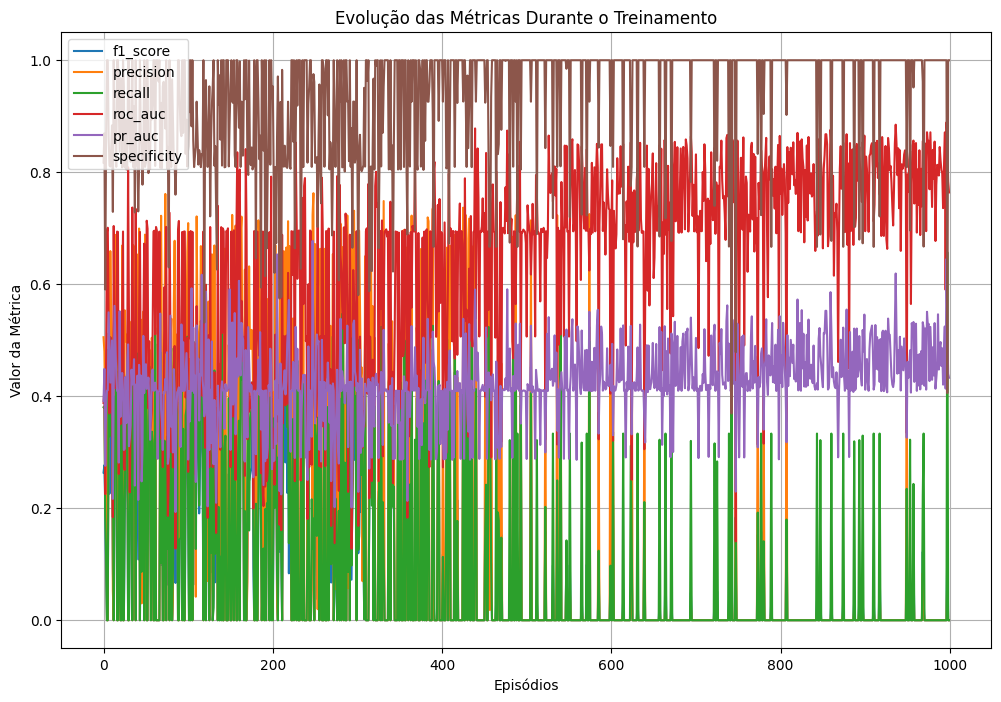

In [512]:
plot_metrics(env.metrics_history)

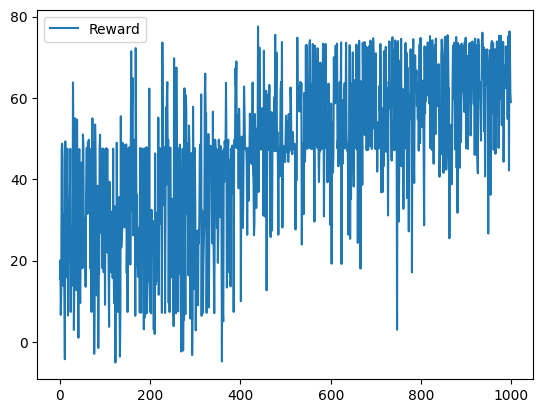

In [513]:
plt.plot(callback.rewards_history, label="Reward")
plt.legend()
plt.show()


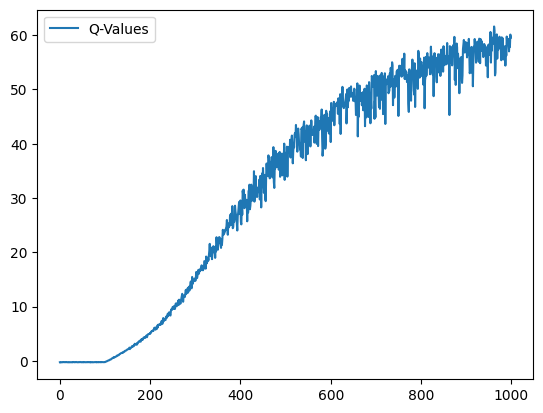

In [514]:
plt.plot(callback.q_values_history, label="Q-Values")
plt.legend()
plt.show()

In [515]:
best_params['params']

{'nu': 0.0001759845035849139,
 'eta0': 0.03431994467973709,
 'learning_rate': 'adaptive',
 'kernel_type': 'rbf',
 'gamma': 0.04215075075626373}

In [516]:
nu_best = round(float(best_params['params'].get('nu')), 4)
eta0_best = round(float(best_params['params'].get('eta0')), 3)
learning_rate_best = best_params['params'].get('learning_rate')
kernel_type_best = best_params['params'].get('kernel_type')

print(f"Melhores hiperparâmetros encontrados: nu={nu_best}, eta0={eta0_best}, learning_rate={learning_rate_best}, kernel_type={kernel_type_best}")

Melhores hiperparâmetros encontrados: nu=0.0002, eta0=0.034, learning_rate=adaptive, kernel_type=rbf


In [517]:
               
estimator = SGDOneClassSVM(nu=nu_best, eta0=eta0_best, learning_rate=learning_rate_best, random_state=42)



In [518]:
transform = Nystroem(gamma=None, random_state=42)
# estimator = estimator_class(random_state=42, **best_params['params'])
estimator = make_pipeline(transform, estimator)

best_model_svm = Pipeline([
            ('scaler', StandardScaler()),
            ('to_dataframe', ToDataFrameTransformer(columns=feature_model)), 
            ('estimator', estimator)
        ])

best_model_svm.fit(X_no_anomalies)

Pipeline(steps=[('scaler', StandardScaler()),
                ('to_dataframe',
                 ToDataFrameTransformer(columns=['P-PDG_mean', 'P-PDG_std',
                                                 'P-PDG_min', 'P-PDG_max',
                                                 'P-TPT_mean', 'P-TPT_std',
                                                 'P-TPT_min', 'P-TPT_max',
                                                 'T-TPT_mean', 'T-TPT_std',
                                                 'T-TPT_min', 'T-TPT_max',
                                                 'P-MON-CKP_mean',
                                                 'P-MON-CKP_std',
                                                 'P-MON-CKP_min',
                                                 'P-MON-CKP_max',
                                                 'T-JUS-CKP_mean',
                                                 'T-JUS-CKP_std',
                                                 'T-JUS-CKP_min',
                                                 'T-JUS-CKP_max',
                                                 'P-JUS-CKGL_mean',
                                                 'P-JUS-CKGL_std',
                                                 'P-JUS-CKGL_min',
                                                 'P-JUS-CKGL_max'])),
                ('estimator',
                 Pipeline(steps=[('nystroem', Nystroem(random_state=42)),
                                 ('sgdoneclasssvm',
                                  SGDOneClassSVM(eta0=0.034,
                                                 learning_rate='adaptive',
                                                 nu=0.0002,
                                                 random_state=42))]))])

In [519]:
y_pred = best_model_svm.predict(validation[feature_model])
y_pred = np.where(y_pred == -1, 1, 0)  


y_test = validation.target.values

Classification Report: 
               precision    recall  f1-score   support

         0.0    0.99008   0.99175   0.99091      5936
         1.0    0.97865   0.97440   0.97652      2305

    accuracy                        0.98689      8241
   macro avg    0.98436   0.98307   0.98372      8241
weighted avg    0.98688   0.98689   0.98689      8241

Specificity: 0.9917452830188679
Gini:  0.9661487537347029
ROC AUC::  0.9830743768673514


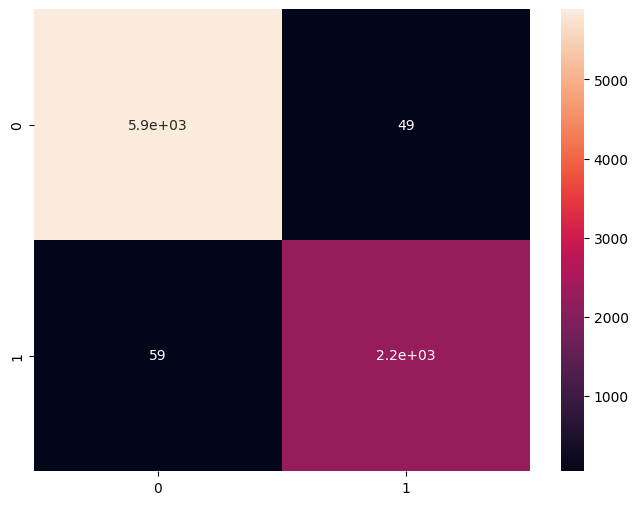

In [520]:
metrics(y_test, y_pred)

In [521]:
with open('./models/pipeline_SGDOSVM_RL.pkl', 'wb') as file: 
    pickle.dump(best_model_svm, file)